# Customer Behaviour Analysis

# Objective
In this case study, you will be working on E-commerce Customer Behavior Analysis using Apache Spark, a powerful distributed computing framework designed for big data processing. This assignment aims to give you hands-on experience in analyzing large-scale e-commerce datasets using PySpark. You will apply techniques learned in data analytics to clean, transform, and explore customer behavior data, drawing meaningful insights to support business decision-making. Apart from understanding how big data tools can optimize performance on a single machine and across clusters, you will develop a structured approach to analyzing customer segmentation, purchase patterns, and behavioral trends.

# Business Value
E-commerce businesses operate in a highly competitive market where understanding customer behavior is critical to driving growth and retention. To stay ahead, companies must leverage data-driven insights to optimize marketing strategies, personalize customer experiences, and improve product offerings. In this assignment, you will analyze e-commerce transaction data to uncover patterns in purchasing behavior, customer preferences, and sales performance. With Apache Spark's ability to handle large datasets efficiently, businesses can process vast amounts of customer interactions in real-time, helping them make faster and more informed decisions.
As an analyst at an e-commerce company, your task is to examine historical transaction records and customer survey data to derive actionable insights that can drive business growth. Your analysis will help identify high-value customers, segment users based on behavior, and uncover trends in product demand and customer engagement. By leveraging big data analytics, businesses can enhance customer satisfaction, improve retention rates, and maximize revenue opportunities.


# Assignment Tasks
1. Data Preparation
2. Data Cleaning
3. Exploratory Data Analysis
4. Customer Segmentation (RFM Analysis) and Business Insights
5. Evaluation and Conclusion


# Dataset Overview
The dataset can be accessed the following [link](https://drive.google.com/drive/folders/1mBgC5tvZrh1bIBvpXVP_j-au5LFUAwOZ?usp=sharing).

The dataset used in this analysis comprises longitudinal purchase records from 5,027 Amazon.com users in the United States, spanning 2018 to 2022.

It is structured into three CSV files (amazon-purchases.csv, survey.csv, and fields.csv) that capture transactional data, demographic profiles, and survey responses.

Collected with informed consent, the dataset enables analysis of customer behavior, product preferences, and demographic trends.

**NOTE**: Personal identifiers (PII) were removed to ensure privacy, and all data were preprocessed by users before submission.

`Data Dictionary:`

| **Attribute**          | **Description** |
|------------------------|----------------|
| **Order Dates**        | The specific dates when orders were placed, enabling chronological analysis of sales trends. |
| **Title** |The name of the product purchased. |
|**Category** | The classification or group to which the product belongs, facilitating category-wise analysis. |
| **Pricing** | The cost per unit of each product, essential for revenue calculations and pricing strategy assessments. |
| **Quantities** | The number of units of each product ordered in a transaction, aiding in inventory and demand analysis. |
| **Shipping States**    | The states to which products were shipped, useful for geographical sales distribution analysis. |
| **Survey ResponseID**  | A unique identifier linking purchases to customer survey responses, enabling correlation between purchasing behavior and customer feedback. |



# Loading the Datasets

In [7]:
## Installing the libraries if required
# !pip install --quiet pyspark==3.5.4 datasets==3.3.2 pandas==2.2.2 matplotlib==3.10.0 seaborn==0.13.2 numpy==1.26.4 tqdm==4.67.1

In [8]:
# Configuring PySpark to use the exact Python interpreter that is running this notebook
import os, sys
os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

In [9]:
# Import necessary libraries
from pyspark.sql import SparkSession

# Initialise Spark session
spark = SparkSession.builder \
    .appName("Customer Behavior Analysis") \
    .getOrCreate()

# Load the paths to the datasets/csv files
amazon_purchases_path = '/C:/Users/uzair/Downloads/amazon-purchases.csv'
survey_path = '/C:/Users/uzair/Downloads/survey.csv'
fields_path = '/C:/Users/uzair/Downloads/fields.csv'

# Load datasets into PySpark DataFrames
amazon_purchases = spark.read.csv(amazon_purchases_path, header = True, inferSchema = True)
survey = spark.read.csv(survey_path, header = True, inferSchema = True)
fields = spark.read.csv(fields_path, header = True, inferSchema = True)

# Merge the datasets
merged_data = amazon_purchases.join(survey, on = 'Survey ResponseID', how = 'left')

# Display the merged data
merged_data.show(truncate = False, vertical = True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Survey ResponseID          | R_01vNIayewjIIKMF                                                                                                                                                                                
 Order Date                 | 2018-12-04                                                                                                                                                                                       
 Purchase Price Per Unit    | 7.98                                                                                                                                                                                             
 Quantity                   | 1.0                                                                       

#1. Data Preparation

Before analysis, the data needs to be prepared to ensure consistency and efficiency.
- Check for data consistency and ensure all columns are correctly formatted.
- Structure and prepare the dataset for further processing, ensuring that relevant features are retained


In [11]:
from pyspark.sql.functions import sum as spark_sum, col

# Check for missing values in the merged dataset
missing_values = merged_data.select([spark_sum(col(c).isNull().cast("integer")).alias(c) for c in merged_data.columns])

In [12]:
# Displaying number of missing values in each column
missing_values.show(truncate = False, vertical = True)

-RECORD 0-----------------------------
 Survey ResponseID          | 144     
 Order Date                 | 0       
 Purchase Price Per Unit    | 0       
 Quantity                   | 0       
 Shipping Address State     | 87812   
 Title                      | 89740   
 ASIN/ISBN (Product Code)   | 960     
 Category                   | 89557   
 Q-demos-age                | 39479   
 Q-demos-hispanic           | 39479   
 Q-demos-race               | 39479   
 Q-demos-education          | 39479   
 Q-demos-income             | 39479   
 Q-demos-gender             | 39479   
 Q-sexual-orientation       | 39479   
 Q-demos-state              | 39479   
 Q-amazon-use-howmany       | 39479   
 Q-amazon-use-hh-size       | 39479   
 Q-amazon-use-how-oft       | 39479   
 Q-substance-use-cigarettes | 39479   
 Q-substance-use-marijuana  | 39479   
 Q-substance-use-alcohol    | 39479   
 Q-personal-diabetes        | 39479   
 Q-personal-wheelchair      | 39479   
 Q-life-changes          

In [13]:
# Inspecting total number of rows in the dataset
merged_data.count()

1850717

In [14]:
# Inspecting the responses present in column "Q-life-changes" (which has significant amount of missing values)
merged_data.groupBy("Q-life-changes").count().orderBy(col("count").desc()).show(n = 200, truncate = False)

+----------------------------------------------------------------+-------+
|Q-life-changes                                                  |count  |
+----------------------------------------------------------------+-------+
|NULL                                                            |1252437|
|Moved place of residence                                        |265490 |
|Lost a job                                                      |131629 |
|Lost a job ,Moved place of residence                            |60165  |
|Became pregnant                                                 |30680  |
|Had a child                                                     |30310  |
|Became pregnant,Had a child                                     |15446  |
|Divorce                                                         |10330  |
|Divorce,Moved place of residence                                |10020  |
|Moved place of residence,Had a child                            |6891   |
|Moved place of residence

In [15]:
1252437/merged_data.count()

0.6767306941039608

### Inference:
- 67.67% of the values in column "Q-life-changes" are missing, this is a significant amount of missing values in a particular column. This will be handled along with missing values of other columns at a later stage.

#2. Data Cleaning <font color = red>[20 marks]</font> <br>

Prepare the data for further analysis by performing data cleaning such as missing value treatment, handle data schema, outlier analysis, and relevant feature engineering techniques.

## 2.1 Handling Missing values <font color = red>[10 marks]</font> <br>
Handle missing values in the data

In [19]:
merged_data.show(truncate = False, vertical = True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Survey ResponseID          | R_01vNIayewjIIKMF                                                                                                                                                                                
 Order Date                 | 2018-12-04                                                                                                                                                                                       
 Purchase Price Per Unit    | 7.98                                                                                                                                                                                             
 Quantity                   | 1.0                                                                       

In [20]:
merged_data = merged_data.drop("Q-life-changes")

### Inference:
- Dropping column "Q-life-changes" since it has 67.67% of its value missing.

In [22]:
missing_values = merged_data.select([spark_sum(col(c).isNull().cast("integer")).alias(c) for c in merged_data.columns])
missing_values.show(truncate = False, vertical = True)

-RECORD 0---------------------------
 Survey ResponseID          | 144   
 Order Date                 | 0     
 Purchase Price Per Unit    | 0     
 Quantity                   | 0     
 Shipping Address State     | 87812 
 Title                      | 89740 
 ASIN/ISBN (Product Code)   | 960   
 Category                   | 89557 
 Q-demos-age                | 39479 
 Q-demos-hispanic           | 39479 
 Q-demos-race               | 39479 
 Q-demos-education          | 39479 
 Q-demos-income             | 39479 
 Q-demos-gender             | 39479 
 Q-sexual-orientation       | 39479 
 Q-demos-state              | 39479 
 Q-amazon-use-howmany       | 39479 
 Q-amazon-use-hh-size       | 39479 
 Q-amazon-use-how-oft       | 39479 
 Q-substance-use-cigarettes | 39479 
 Q-substance-use-marijuana  | 39479 
 Q-substance-use-alcohol    | 39479 
 Q-personal-diabetes        | 39479 
 Q-personal-wheelchair      | 39479 
 Q-sell-YOUR-data           | 39479 
 Q-sell-consumer-data       | 39479 
 

In [23]:
# Import necessary functions
# from pyspark.sql.functions import when

# Fill missing (null) values with the appropriate techniques as required by the analysis
merged_data = merged_data.dropna(how = 'any')

### Inference:
- Since the maximum amount of missing value in any particular column is only 7.15% (89557/1252437), it makes sense to drop the null values entirely to maintain the sanctity of the dataset instead of compromising the results of the analysis by replacing null values with metrics such mean, median, mode, etc.

In [25]:
# Aggregate and count missing values (nulls) for each column after replacement
missing_values = merged_data.select([spark_sum(col(c).isNull().cast("integer")).alias(c) for c in merged_data.columns])

# Display the count of remaining missing values in each column
missing_values.show(truncate = False, vertical = True)

-RECORD 0-------------------------
 Survey ResponseID          | 0   
 Order Date                 | 0   
 Purchase Price Per Unit    | 0   
 Quantity                   | 0   
 Shipping Address State     | 0   
 Title                      | 0   
 ASIN/ISBN (Product Code)   | 0   
 Category                   | 0   
 Q-demos-age                | 0   
 Q-demos-hispanic           | 0   
 Q-demos-race               | 0   
 Q-demos-education          | 0   
 Q-demos-income             | 0   
 Q-demos-gender             | 0   
 Q-sexual-orientation       | 0   
 Q-demos-state              | 0   
 Q-amazon-use-howmany       | 0   
 Q-amazon-use-hh-size       | 0   
 Q-amazon-use-how-oft       | 0   
 Q-substance-use-cigarettes | 0   
 Q-substance-use-marijuana  | 0   
 Q-substance-use-alcohol    | 0   
 Q-personal-diabetes        | 0   
 Q-personal-wheelchair      | 0   
 Q-sell-YOUR-data           | 0   
 Q-sell-consumer-data       | 0   
 Q-small-biz-use            | 0   
 Q-census-use       

### Checking dtypes of columns

In [27]:
merged_data.printSchema()

root
 |-- Survey ResponseID: string (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Purchase Price Per Unit: double (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- Shipping Address State: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ASIN/ISBN (Product Code): string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Q-demos-age: string (nullable = true)
 |-- Q-demos-hispanic: string (nullable = true)
 |-- Q-demos-race: string (nullable = true)
 |-- Q-demos-education: string (nullable = true)
 |-- Q-demos-income: string (nullable = true)
 |-- Q-demos-gender: string (nullable = true)
 |-- Q-sexual-orientation: string (nullable = true)
 |-- Q-demos-state: string (nullable = true)
 |-- Q-amazon-use-howmany: string (nullable = true)
 |-- Q-amazon-use-hh-size: string (nullable = true)
 |-- Q-amazon-use-how-oft: string (nullable = true)
 |-- Q-substance-use-cigarettes: string (nullable = true)
 |-- Q-substance-use-marijuana: strin

### Inference:
- At a quick glance, dtypes of the columns look appropriate. Further conversion of dtypes will be done as and when the need arises.

### Sanctity Check

In [30]:
# Checking for rows with zero or negative value in column 'Purchase Price Per Unit'
zero_or_negative_values_price = merged_data.filter(col('Purchase Price Per Unit') <= 0)

zero_or_negative_values_price.show(truncate = False, vertical = True)

(0 rows)



#### Inference:
- No row with zero or negative value present in the column.

In [32]:
# Checking for rows with zero or negative value in column 'Quantity'
zero_or_negative_values_quantity = merged_data.filter(col('Quantity') <= 0)

zero_or_negative_values_quantity.show(truncate = False, vertical = True)

(0 rows)



#### Inference:
- No row with zero or negative value present in the column.

### Outlier Analysis

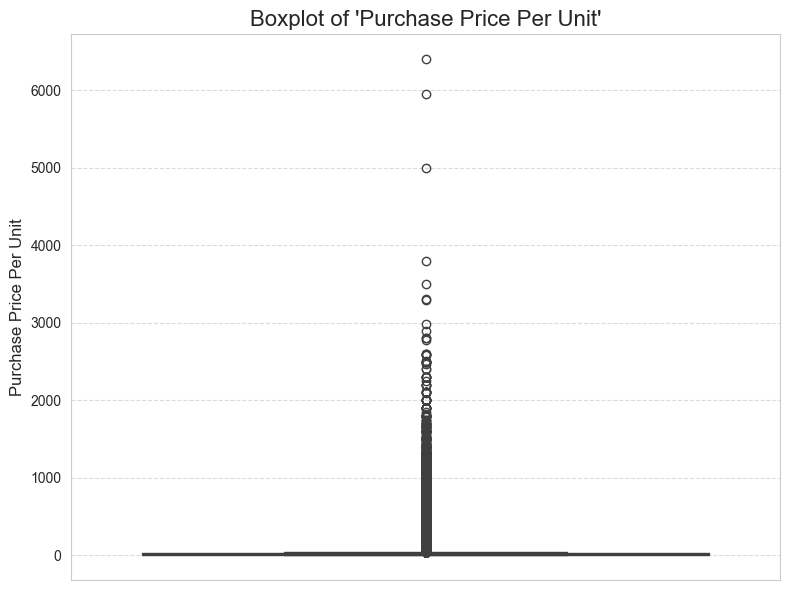

In [35]:
# Importing relevant libraries
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")

# Creating boxplot for column 'Purchase Price Per Unit'
price_pd_series = merged_data.select('Purchase Price Per Unit').toPandas()['Purchase Price Per Unit']

plt.figure(figsize=(8, 6))
sns.boxplot(y=price_pd_series)
plt.title("Boxplot of 'Purchase Price Per Unit'", fontsize=16)
plt.ylabel('Purchase Price Per Unit', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inference:
- No value which should be considered as an outlier observed.

In [37]:
# Creating boxplot for column 'Quantity'
quantity_pd_series = merged_data.select('Quantity').toPandas()['Quantity']

plt.figure(figsize=(8, 6))
sns.boxplot(y=quantity_pd_series)
plt.title("Boxplot of 'Quantity'", fontsize=16)
plt.ylabel('Quantity', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inference:
- No value which should be considered as an outlier observed.

### Checking percentage of rows retained after the removal of missing values

In [40]:
merged_data.count()/1850717

0.8842664761819338

### Inference:
- We have retained 88.43% of the rows of the original dataset after the removal of missing values.

## 2.2 Feature Engineering <font color = red>[5 marks]</font> <br>
Perform feature engineering on the dataset to extract relevant/ create new features as required and map specific data types.

In [43]:
from pyspark.sql.functions import col, month, year, to_date, dayofmonth

# Perform appropriate feature engineering. Eg. Extract order date, month, year and cast to the appropriate values

### Defining the name of the column containing the date string
date_column_name = "Order Date"

### Defining the format of the date string to be parsed
date_format = "yyyy-MM-dd"

### Parsing the 'Order Date' string column into a proper date type.
df_with_date_type = merged_data.withColumn(
            "parsed_date",
            to_date(col('Order Date'), date_format)
)

### Extracting day, month, and year components from the 'parsed_date' column.
merged_data = df_with_date_type.withColumn("day", dayofmonth(col("parsed_date"))) \
                               .withColumn("month", month(col("parsed_date"))) \
                               .withColumn("year", year(col("parsed_date")))

# Display the updated dataset
merged_data.show(truncate = False, vertical = True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Survey ResponseID          | R_01vNIayewjIIKMF                                                                                                                                                                                
 Order Date                 | 2018-12-04                                                                                                                                                                                       
 Purchase Price Per Unit    | 7.98                                                                                                                                                                                             
 Quantity                   | 1.0                                                                       

In [44]:
from pyspark.sql.functions import create_map, lit, when
from itertools import chain

# Map categorical income to numerical values
income_mapping = {
    'Less than $25,000': 0,
    '$25,000 - $49,999': 1,
    '$50,000 - $74,999': 2,
    '$75,000 - $99,999': 3,
    '$100,000 - $149,999': 4,
    '$150,000 or more': 5
}

# Map gender to numerical values
gender_mapping = {
    'Female': 0,
    'Male': 1,
    'Other': 2,
    'Prefer not to say': 3
}

### Converting Python dictionaries to PySpark map expressions.
mapping_expr_income = create_map([lit(x) for x in chain.from_iterable(income_mapping.items())])
mapping_expr_gender = create_map([lit(x) for x in chain.from_iterable(gender_mapping.items())])

### Applying the created map expressions to the respective columns in 'merged_data'.
df_mapped = merged_data.withColumn("income_numerical", mapping_expr_income[col("Q-demos-income")]) \
              .withColumn("gender_numerical", mapping_expr_gender[col("Q-demos-gender")])

### Handle unmapped values and nulls for 'income_numerical'.
merged_data = df_mapped.withColumn(
    "income_numerical",
    when(col("Q-demos-income").isNull(), None)
    .when(col("income_numerical").isNull(), lit(-1))
    .otherwise(col("income_numerical"))
)

### Handling unmapped values and nulls for 'gender_numerical'.
merged_data = merged_data.withColumn(
    "gender_numerical",
    when(col("Q-demos-gender").isNull(), None)
    .when(col("gender_numerical").isNull(), lit(-1))
    .otherwise(col("gender_numerical"))
)

# Display the updated dataset
merged_data.show(truncate = False, vertical = True)

-RECORD 0----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Survey ResponseID          | R_01vNIayewjIIKMF                                                                                                                                                                                
 Order Date                 | 2018-12-04                                                                                                                                                                                       
 Purchase Price Per Unit    | 7.98                                                                                                                                                                                             
 Quantity                   | 1.0                                                                       

## 2.3 Data Cleaning <font color = red>[5 marks]</font> <br>
Handle data cleaning techniques such as data duplication, dropping unnecessary values etc.

In [46]:
# Check for duplicates
print("Number of Duplicates:", merged_data.count() - merged_data.dropDuplicates().count())

# Remove duplicates
merged_data = merged_data.dropDuplicates()

# Verify duplicates after cleaning
print("Number of Duplicates After Cleaning:", merged_data.count() - merged_data.dropDuplicates().count())

Number of Duplicates: 4811
Number of Duplicates After Cleaning: 0


In [47]:
cleaned_data_path = '/C:/Users/uzair/Downloads/cleaned_data/'  # Save the cleaned dataset locally

merged_data.write.csv(cleaned_data_path, header=True, mode='overwrite')

# Load the cleaned dataset from the location
cleaned_data = spark.read.csv(cleaned_data_path, header=True, inferSchema=True)

# Display the first few rows
print("Cleaned Data:")
cleaned_data.show(truncate = False, vertical = True)

Cleaned Data:
-RECORD 0--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Survey ResponseID          | R_037XK72IZBJyF69                                                                                                                                                                                          
 Order Date                 | 2018-04-02                                                                                                                                                                                                 
 Purchase Price Per Unit    | 19.99                                                                                                                                                                                                      
 Quantity                   | 1.0                 

# 3. Exploratory Data Analysis <font color = red>[55 marks]</font> <br>

## 3.1 Analyse purchases by hour, day and month <font color = red>[5 marks]</font> <br>

Examine overall trends in purchases over time and analyse the trends by hour, day, month.

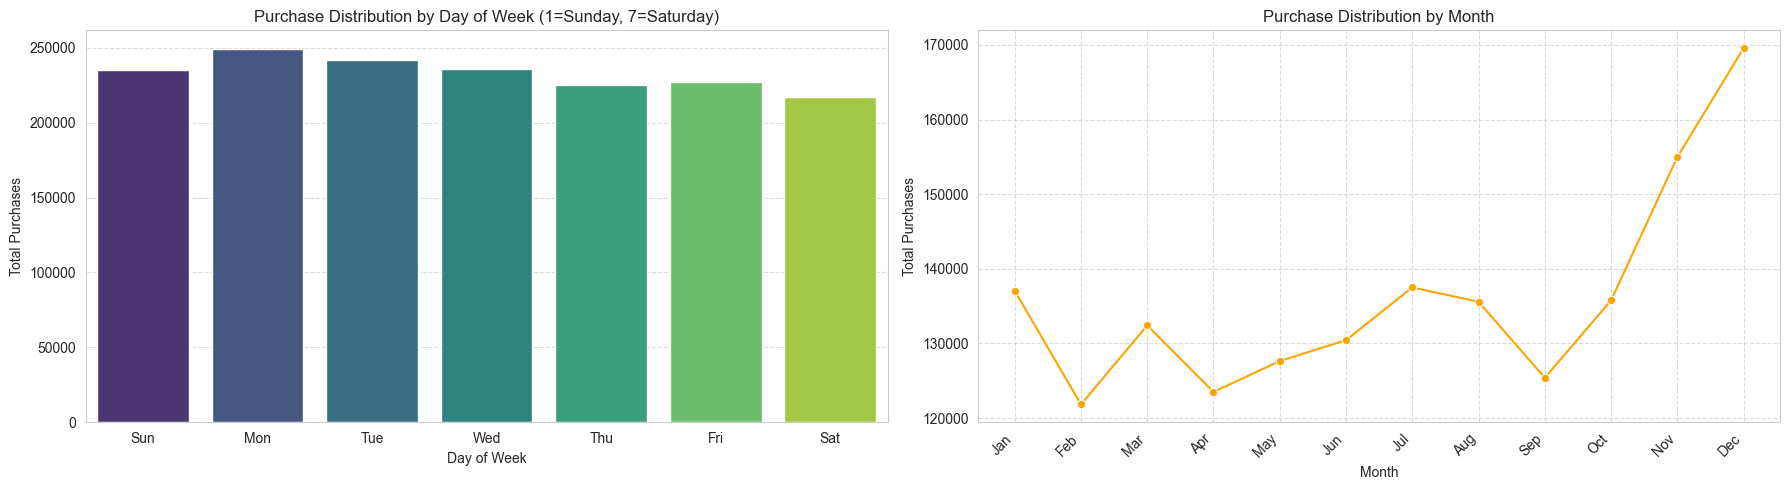

In [50]:
# Purchase Distribution by Hour, Day and Month

from pyspark.sql.functions import hour, dayofweek, month, count
import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# sns.set_style("whitegrid")

# Extract hour, day, and month
### Extracting day and month
df_with_time_features = cleaned_data.withColumn("purchase_day_of_week", dayofweek(col("parsed_date"))) \
                                    .withColumn("purchase_month", month(col("parsed_date")))

# Group and count purchases by time factors
### Group and count purchases by Day of Week
purchase_by_day_of_week = df_with_time_features.groupBy("purchase_day_of_week") \
                                               .agg(count("parsed_date").alias("total_purchases")) \
                                               .orderBy("purchase_day_of_week")

### Group and count purchases by Month
purchase_by_month = df_with_time_features.groupBy("purchase_month") \
                                         .agg(count("parsed_date").alias("total_purchases")) \
                                         .orderBy("purchase_month")

# Convert to Pandas for visualisation
purchase_by_day_of_week_pd = purchase_by_day_of_week.toPandas()
purchase_by_month_pd = purchase_by_month.toPandas()

### Mapping numerical day of week to names for plotting
day_names_map = {
    1: 'Sun', 2: 'Mon', 3: 'Tue', 4: 'Wed',
    5: 'Thu', 6: 'Fri', 7: 'Sat'
}
purchase_by_day_of_week_pd['purchase_day_of_week_name'] = purchase_by_day_of_week_pd['purchase_day_of_week'].map(day_names_map)

### Ensuring the order of days for plotting using pd.Categorical
ordered_day_names = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
purchase_by_day_of_week_pd['purchase_day_of_week_name'] = pd.Categorical(
    purchase_by_day_of_week_pd['purchase_day_of_week_name'],
    categories=ordered_day_names,
    ordered=True
)
purchase_by_day_of_week_pd = purchase_by_day_of_week_pd.sort_values('purchase_day_of_week_name')

### Mapping numerical month to names for plotting
month_names_map = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}
purchase_by_month_pd['purchase_month_name'] = purchase_by_month_pd['purchase_month'].map(month_names_map)

### Ensuring the order of months for plotting using pd.Categorical
ordered_month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
purchase_by_month_pd['purchase_month_name'] = pd.Categorical(
    purchase_by_month_pd['purchase_month_name'],
    categories=ordered_month_names,
    ordered=True
)
purchase_by_month_pd = purchase_by_month_pd.sort_values('purchase_month_name')

# Plot the data
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Purchase Distribution by Day of Week
sns.barplot(
    x='purchase_day_of_week_name',
    y='total_purchases',
    data=purchase_by_day_of_week_pd,
    palette='viridis',
    hue='purchase_day_of_week_name',
    ax=axes[0],
    legend=False
)
axes[0].set_title('Purchase Distribution by Day of Week (1=Sunday, 7=Saturday)')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Total Purchases')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 2: Purchase Distribution by Month
sns.lineplot(
    x='purchase_month_name',
    y='total_purchases',
    data=purchase_by_month_pd,
    marker='o',
    ax=axes[1],
    color='orange'
)
axes[1].set_title('Purchase Distribution by Month')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Total Purchases')
axes[1].set_xticks(range(len(ordered_month_names)))
axes[1].set_xticklabels(ordered_month_names, rotation=45, ha='right')
axes[1].grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

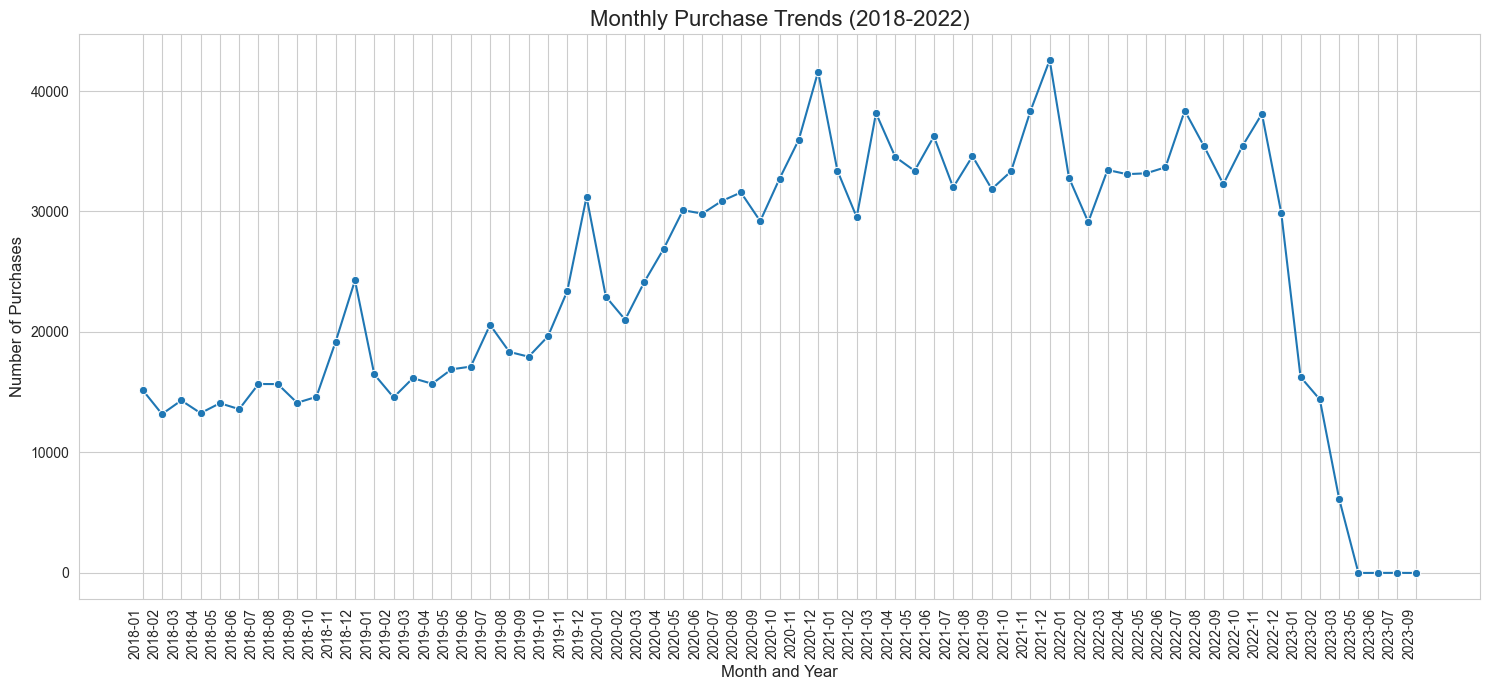

In [51]:
# Monthly Purchase Trends

from pyspark.sql.functions import date_format

# Extract month and year from 'Order Date'
cleaned_data_monthly = cleaned_data.withColumn(
    "MonthYear", date_format(col("parsed_date"), "yyyy-MM")
)

# Group by month and count purchases
### The result is ordered by 'MonthYear' to ensure chronological plotting
cleaned_data_monthly_count = cleaned_data_monthly.groupBy("MonthYear").agg(
    count("*").alias("TotalPurchases")
).orderBy("MonthYear")

# Convert to Pandas for visualisation
cleaned_data_monthly_count_pd = cleaned_data_monthly_count.toPandas()

# Plot
plt.figure(figsize=(15, 7))
sns.lineplot(
    data=cleaned_data_monthly_count_pd,
    x="MonthYear",
    y="TotalPurchases",
    marker="o"
)
plt.title("Monthly Purchase Trends (2018-2022)", fontsize=16)
plt.xlabel("Month and Year", fontsize=12)
plt.ylabel("Number of Purchases", fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

### Note:
- The fall at the end of the line plot is due to the insufficiency of data post 2022. This can be checked with the help of the code given below.

In [53]:
# Getting the count of all transactions
total_transactions_count = cleaned_data.count()
print(f"Total number of transactions: {total_transactions_count}")

# Getting the count of transactions in 2022 using the 'parsed_date' column
transactions_2022 = cleaned_data.filter(year(col("parsed_date")) == 2022)
count_2022 = transactions_2022.count()
print(f"Number of transactions in 2022: {count_2022}")

# Getting the count of transactions in 2023 using the 'parsed_date' column
transactions_2023 = cleaned_data.filter(year(col("parsed_date")) == 2023)
count_2023 = transactions_2023.count()
print(f"Number of transactions in 2023: {count_2023}")

# Comparing the counts
percentage_2023 = (count_2023 / count_2022) * 100
print(f"\nTransactions in 2023 account for {percentage_2023:.2f}% of transactions in 2022.")

# Comparing the counts
percentage_2023 = (count_2023 / total_transactions_count) * 100
print(f"Transactions in 2023 account for {percentage_2023:.2f}% of total transactions.")

Total number of transactions: 1631716
Number of transactions in 2022: 404804
Number of transactions in 2023: 36841

Transactions in 2023 account for 9.10% of transactions in 2022.
Transactions in 2023 account for 2.26% of total transactions.


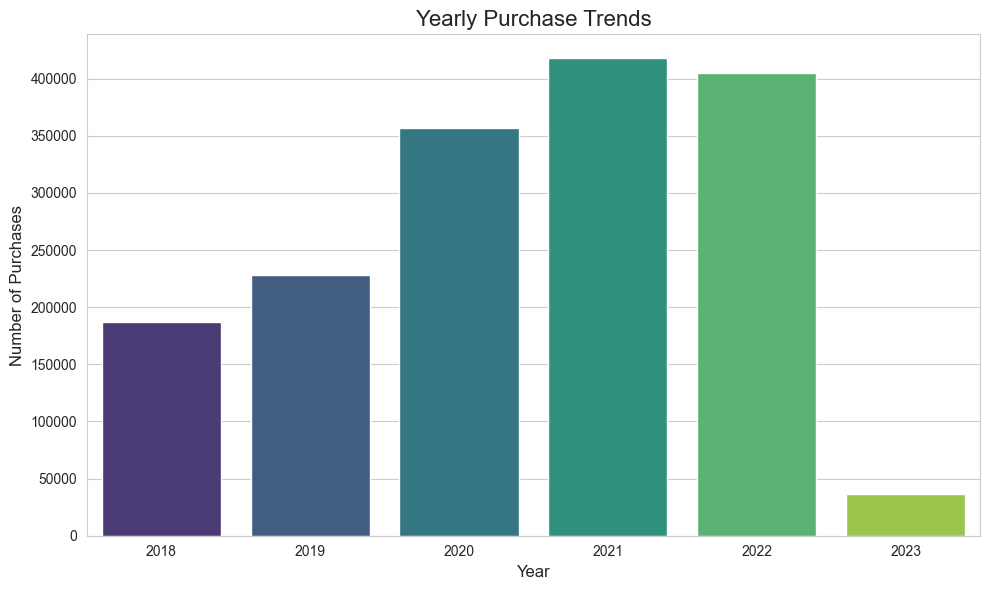

In [54]:
# Yealy Purchase Trends

# from pyspark.sql.functions import date_format

# Extract year from 'Order Date'
df_yearly = cleaned_data.withColumn(
    "Year", date_format(col("parsed_date"), "yyyy")
)

# Group by Year and count purchases
### The result is ordered by 'Year' to ensure chronological plotting
yearly_purchase_counts = df_yearly.groupBy("Year").agg(
    count("*").alias("TotalPurchases")
).orderBy("Year")

# Convert to Pandas for visualisation
yearly_purchase_counts_pd = yearly_purchase_counts.toPandas()

# Plot
plt.figure(figsize=(10, 6)) 
sns.barplot(
    data=yearly_purchase_counts_pd,
    x="Year",
    y="TotalPurchases",
    palette="viridis",
    hue="Year",
    legend=False
)

plt.title("Yearly Purchase Trends", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Purchases", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Note:
- Here also, the bar of 2023 is short due to the insufficiency of data post 2022.

## 3.2 Customer Demographics vs Purchase Frequency <font color = red>[5 marks]</font> <br>
Analyse the trends between the customer deographics and the purchase frequency


Analyzing Purchase Frequency by Q-demos-age:


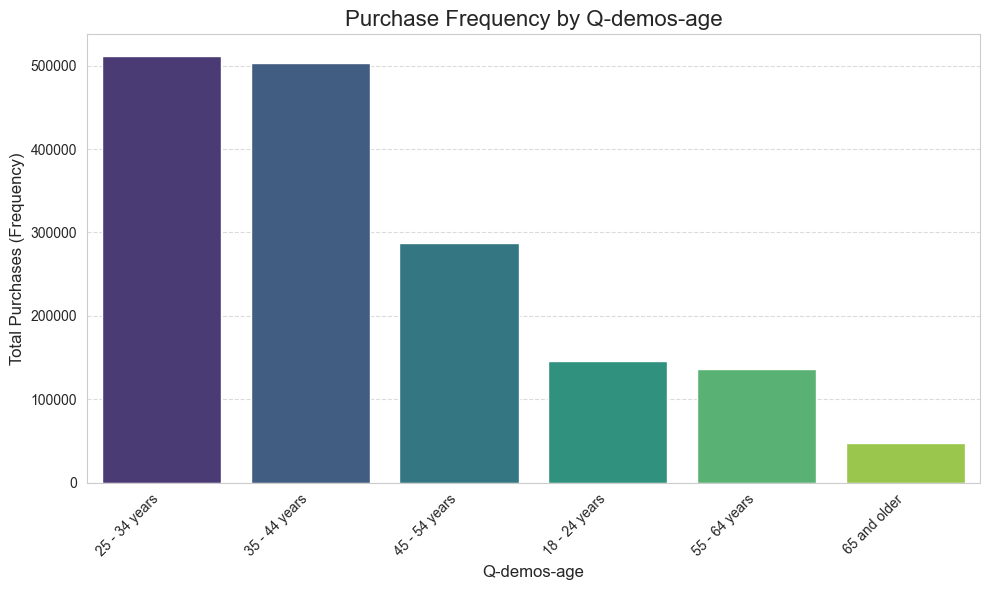


Analyzing Purchase Frequency by Q-demos-education:



Analyzing Purchase Frequency by Q-demos-income:



Analyzing Purchase Frequency by Q-demos-gender:



Analyzing Purchase Frequency by Q-sexual-orientation:


In [57]:
# Listing demographic columns to analyze (5 variables)
demographic_columns = [
    "Q-demos-age",
    "Q-demos-education",
    "Q-demos-income",
    "Q-demos-gender",
    "Q-sexual-orientation"
]

# Iterating through each demographic column to generate individual plots
for demo_col in demographic_columns:
    print(f"\nAnalyzing Purchase Frequency by {demo_col}:")

    # Grouping by demographic attribute and counting the number of transactions/rows
    df_grouped = cleaned_data.groupBy(demo_col).agg(count("*").alias("Total Purchases"))

    # Converting to Pandas for visualization
    purchase_frequency_pd = df_grouped.toPandas()

    # Applying consistent sorting by Total Purchases (descending) for all plots
    purchase_frequency_pd = purchase_frequency_pd.sort_values("Total Purchases", ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x=demo_col,
                y="Total Purchases",
                hue=demo_col,
                data=purchase_frequency_pd,
                palette='viridis',
                legend=False)

    plt.title(f'Purchase Frequency by {demo_col}', fontsize=16)
    plt.xlabel(demo_col, fontsize=12)
    plt.ylabel('Total Purchases (Frequency)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 3.3 Purchase behavior weekend vs weekday <font color = red>[5 marks]</font> <br>

Compare the purchase behavior of customer's on weekdays vs. weekends.

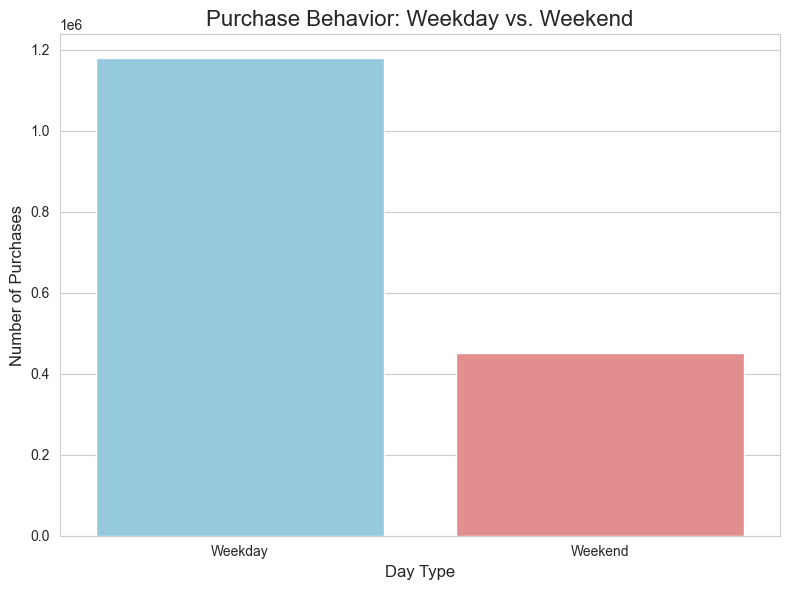

In [59]:
# Weekday vs. Weekend Purchase Behavior

from pyspark.sql.functions import when
import pandas as pd

# Define weekdays and weekends
df_weekday_weekend = cleaned_data.withColumn(
    "DayType",
    when(
        (dayofweek(col("parsed_date")) == 1) | (dayofweek(col("parsed_date")) == 7),
        "Weekend"
    ).otherwise("Weekday")
)

# Group and count purchases
weekday_weekend_counts = df_weekday_weekend.groupBy("DayType").agg(
    count("*").alias("TotalPurchases")
)

# Convert to Pandas for visualisation
weekday_weekend_counts_pd = weekday_weekend_counts.toPandas()

# Plot

### Ensuring the order for plotting (Weekday then Weekend)
order = ["Weekday", "Weekend"]
weekday_weekend_counts_pd["DayType"] = pd.Categorical(
    weekday_weekend_counts_pd["DayType"], categories=order, ordered=True
)

### Sorting the DataFrame by the ordered categorical column to ensure the plot respects the order.
weekday_weekend_counts_pd = weekday_weekend_counts_pd.sort_values("DayType")

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    data=weekday_weekend_counts_pd,
    x="DayType",
    y="TotalPurchases",
    hue="DayType",
    palette={"Weekday": "skyblue", "Weekend": "lightcoral"},
    legend=False
)

plt.title("Purchase Behavior: Weekday vs. Weekend", fontsize=16)
plt.xlabel("Day Type", fontsize=12)
plt.ylabel("Number of Purchases", fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## 3.4 Frequently purchased product pairs <font color = red>[5 marks]</font> <br>

Analyze how frequently products are purchased together (also known as Market Basket Analysis)


In [61]:
# Frequently Purchased Product Pairs (Market Basket Analysis)

from pyspark.sql.functions import collect_set, explode, concat, lit, size
from itertools import combinations

# Group purchases by customer and collect items bought together
product_id_column = "ASIN/ISBN (Product Code)"

### Grouping by a unique transaction identifier and collecting all product codes in that transaction
transactions_df = cleaned_data.withColumn(
    "TransactionID",
    concat(col("Survey ResponseID"), date_format(col("parsed_date"), "yyyyMMddHHmmss"))
).groupBy(
    "TransactionID"
).agg(
    collect_set(col(product_id_column)).alias("products_in_basket")
).filter(
    size(col("products_in_basket")) >= 2
)

# Explode item pairs
products_in_basket_pd = transactions_df.toPandas()

### Generating all unique pairs for each basket
all_pairs = []
for products_list in products_in_basket_pd['products_in_basket']:
    for p1, p2 in combinations(sorted(products_list), 2):
        all_pairs.append(tuple(sorted((p1, p2))))

### Converting list of pairs to a Pandas DataFrame
pairs_df_pd = pd.DataFrame(all_pairs, columns=['Product1', 'Product2'])

# Count co-occurrences of items
### Grouping by pairs and counting their occurrences
co_occurrences_pd = pairs_df_pd.groupby(['Product1', 'Product2']).size().reset_index(name='count')
co_occurrences_pd = co_occurrences_pd.sort_values(by='count', ascending=False)

# Plot
top_n_pairs = 15
top_co_occurrences_pd = co_occurrences_pd.head(top_n_pairs)

### Creating a combined label for plotting
top_co_occurrences_pd['Product_Pair'] = top_co_occurrences_pd['Product1'] + " & " + top_co_occurrences_pd['Product2']

plt.figure(figsize=(12, 8))
sns.barplot(
    x='count',
    y='Product_Pair',
    data=top_co_occurrences_pd,
    hue='Product_Pair',
    palette='viridis',
    legend=False
)
plt.title(f'Top {top_n_pairs} Frequently Purchased Product Pairs', fontsize=16)
plt.xlabel('Number of Co-occurrences', fontsize=12)
plt.ylabel('Product Pair', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

C:\Users\uzair\AppData\Local\Temp\ipykernel_48972\4035783683.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_co_occurrences_pd['Product_Pair'] = top_co_occurrences_pd['Product1'] + " & " + top_co_occurrences_pd['Product2']


## 3.5 Examine Product Performance <font color = red>[5 marks]</font> <br>

Examine the performance of products by calculating revenue and item popularity.

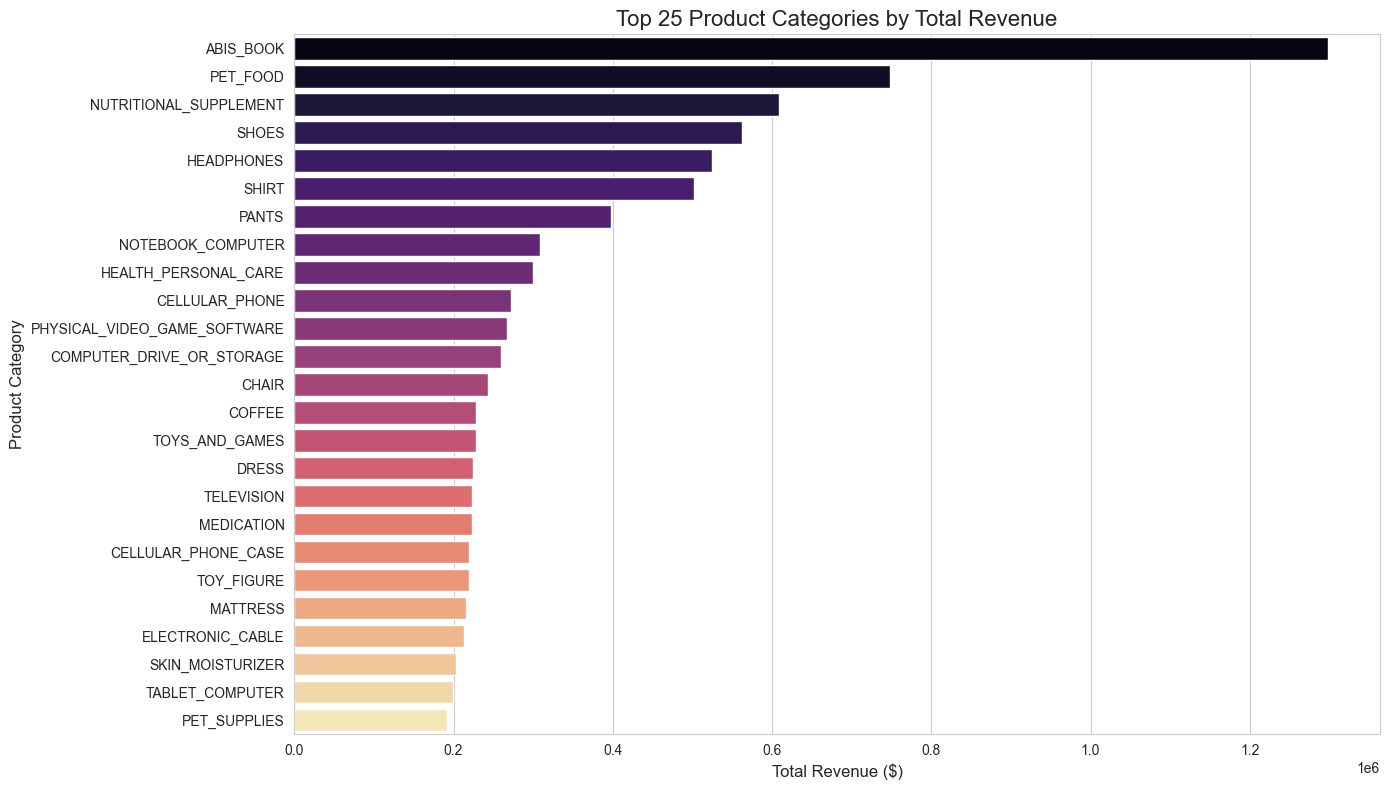

In [63]:
from pyspark.sql.functions import sum, avg # col

# Contribution of Product Categories (Top 25)

### Preparing numerical price and quantity columns.
### Casting 'Purchase Price Per Unit' to DecimalType (10 digits total, 2 after decimal) for precise monetary calculations.
### Casting 'Quantity' to IntegerType to ensure it's treated as a whole number.
cleaned_data = cleaned_data.withColumn("Price_numeric", col("Purchase Price Per Unit").cast("decimal(10, 2)"))
cleaned_data = cleaned_data.withColumn("Quantity_numeric", col("Quantity").cast("integer"))

### Filtering out rows where either Price_numeric or Quantity_numeric is not positive.
df_products_cleaned = cleaned_data.filter(
    (col("Price_numeric") > 0) & (col("Quantity_numeric") > 0)
)

### Calculating product category performance.
product_category_performance = df_products_cleaned.groupBy("Category").agg(
    sum(col("Price_numeric") * col("Quantity_numeric")).alias("TotalRevenue"),
    sum(col("Quantity_numeric")).alias("TotalItemsSold"),
)

### Ordering categories by 'TotalRevenue' in descending order to identify top performers.
product_category_performance = product_category_performance.orderBy(col("TotalRevenue").desc())

# Convert to Pandas for visualisation
product_category_performance_pd = product_category_performance.limit(25).toPandas()

# Plot
n_top=25

### Plotting Contribution by Total Revenue (Top 25 Categories).
plt.figure(figsize=(14, 8))
sns.barplot(
    data=product_category_performance_pd,
    y="Category",
    x="TotalRevenue",
    hue="Category",
    palette="magma",
    legend=False
)
plt.title(f"Top {n_top} Product Categories by Total Revenue", fontsize=16)
plt.xlabel("Total Revenue ($)", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.tight_layout()
plt.show()

### Plotting Total Items Sold (as a measure of popularity) for Top 25 Categories.
plt.figure(figsize=(14, 8))
sns.barplot(
    data=product_category_performance_pd,
    y="Category",
    x="TotalItemsSold",
    hue="Category",
    palette="viridis",
    legend=False
)
plt.title(f"Top {n_top} Product Categories by Total Items Sold", fontsize=16)
plt.xlabel("Total Items Sold", fontsize=12)
plt.ylabel("Product Category", fontsize=12)
plt.tight_layout()
plt.show()

## 3.6 Top products by quantity <font color = red>[5 marks]</font> <br>

Identify the most frequently purchased products.

In [65]:
# Top 10 Products by Quantity

# Group by product title and sum 'Quantity'
### Grouping by product 'Title' and summing the 'Quantity_numeric' to find total items sold.
product_popularity = df_products_cleaned.groupBy("ASIN/ISBN (Product Code)").agg(
    sum(col("Quantity_numeric")).alias("TotalQuantitySold")
)

### Ordering products by 'TotalQuantitySold' in descending order.
product_popularity = product_popularity.orderBy(col("TotalQuantitySold").desc())

# Convert to Pandas for visualisation
product_popularity_pd = product_popularity.limit(10).toPandas()

# Plot
n_top=10
plt.figure(figsize=(12, 7))
sns.barplot(
    data=product_popularity_pd,
    y="ASIN/ISBN (Product Code)",
    x="TotalQuantitySold",
    hue="ASIN/ISBN (Product Code)",
    palette="rocket",
    legend=False
)
plt.title(f"Top {n_top} Most Frequently Purchased Products by Quantity", fontsize=16)
plt.xlabel("Total Quantity Sold", fontsize=12)
plt.ylabel("ASIN/ISBN (Product Code)", fontsize=12)
plt.tight_layout()
plt.show()

## 3.7 Distribution of Purchases by State <font color = red>[5 marks]</font> <br>

Analyze the distribution of purchases across states and categories.

In [67]:
# Distribution of Purchases by State (Top 25)

### Grouping data by 'Shipping Address State' and counting total purchases per state.
state_purchase_distribution = cleaned_data.groupBy("Shipping Address State").agg(
    count("*").alias("TotalPurchases")
)

### Ordering states by 'TotalPurchases' in descending order.
state_purchase_distribution = state_purchase_distribution.orderBy(col("TotalPurchases").desc())

# Convert to Pandas for visualisation
state_purchase_distribution_pd = state_purchase_distribution.limit(25).toPandas()

# Plot
n_top=25
plt.figure(figsize=(12, 8))
sns.barplot(
    data=state_purchase_distribution_pd,
    y="Shipping Address State",
    x="TotalPurchases",
    hue="Shipping Address State",
    palette="viridis",
    legend=False
)
plt.title(f"Top {n_top} States by Total Purchases", fontsize=16)
plt.xlabel("Total Number of Purchases", fontsize=12)
plt.ylabel("Shipping Address State", fontsize=12)
plt.tight_layout()
plt.show()

## 3.8 Price vs Product Quantity <font color = red>[5 marks]</font> <br>

Identify the Relationship between Price and Quantity

In [69]:
# Relationship Between Price and Quantity

### Filtering data for positive price and quantity.
df_filtered_for_scatter = cleaned_data.filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

### Selecting and aliasing the numeric price and quantity columns for plotting.
df_plot_data = df_filtered_for_scatter.select(
    col("Price_numeric").alias("Price"),
    col("Quantity_numeric").alias("Quantity")
)

# Convert to Pandas for visualisation
price_quantity_pd = df_plot_data.toPandas()

# Plot
plt.figure(figsize=(10, 8))

### Plotting the relationship between Price and Quantity using a scatter plot.
sns.scatterplot(
    data=price_quantity_pd,
    x="Price",
    y="Quantity",
    alpha=0.2,
    s=20,
    color="purple"
)
plt.title("Relationship Between Purchase Price Per Unit and Quantity", fontsize=16)
plt.xlabel("Purchase Price Per Unit ($)", fontsize=12)
plt.ylabel("Quantity Purchased", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## 3.9 Analyse the spending KPIs <font color = red>[5 marks]</font> <br>


A popular KPI is average spend per customer. Calculate this metric as the ratio of total transaction amount from non-recurring payments divided by the total number of customers who made a purchase

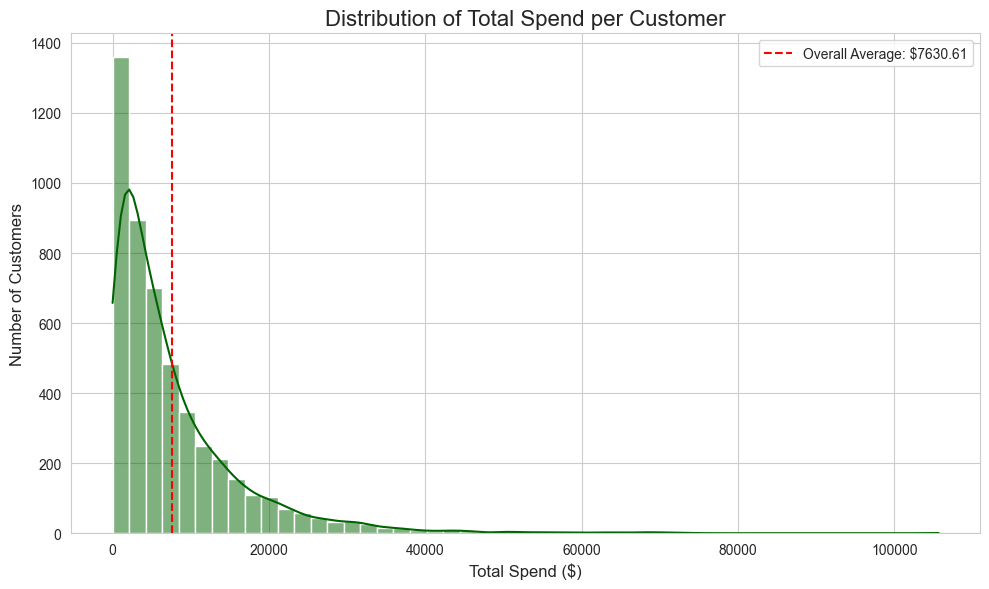

In [71]:
# Average Spend per Customer

# from pyspark.sql.functions import col, sum, avg

### Filtering data for positive price and quantity, and calculating total value for each line item
df_prepared_for_spend = cleaned_data.filter(
    (col("Price_numeric") > 0) & (col("Quantity_numeric") > 0)
).withColumn(
    "LineItemTotal",
    col("Price_numeric") * col("Quantity_numeric")
)

# Group by customer and calculate average spend
customer_total_spend = df_prepared_for_spend.groupBy("Survey ResponseID").agg(
    sum("LineItemTotal").alias("TotalSpend")
)

### Calculating the overall average spend across all customers.
overall_average_spend = customer_total_spend.agg(avg("TotalSpend")).collect()[0][0]

# Convert to Pandas for visualisation
customer_total_spend_pd = customer_total_spend.toPandas()

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(
    data=customer_total_spend_pd,
    x="TotalSpend",
    bins=50,
    kde=True,
    color="darkgreen"
)

### Adding a vertical line for the overall average spend
plt.axvline(overall_average_spend, color='red', linestyle='--', label=f'Overall Average: ${overall_average_spend:.2f}')
plt.title("Distribution of Total Spend per Customer", fontsize=16)
plt.xlabel("Total Spend ($)", fontsize=12)
plt.ylabel("Number of Customers", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

Analyse the Repeat Purchase Behavior of Customers

In [73]:
# Repeat Purchase Analysis Behavior Per Customers

### Counting total purchases per customer.
### Grouping 'cleaned_data' by 'Survey ResponseID' and counting the number of purchases for each customer.
customer_purchase_counts = cleaned_data.groupBy("Survey ResponseID").agg(
    count("Survey ResponseID").alias("total_purchases")
)

### Identifying repeat customers (those with more than 1 purchase).
repeat_customers_df = customer_purchase_counts.filter(col("total_purchases") > 1)

### Calculating metrics for repeat purchase behavior.
total_unique_customers = customer_purchase_counts.count()
num_repeat_customers = repeat_customers_df.count()

### Calculating the percentage of repeat customers.
percentage_repeat_customers = (num_repeat_customers / total_unique_customers) * 100 if total_unique_customers > 0 else 0

### Calculating the average number of purchases made by repeat customers.
avg_purchases_repeat_customers = repeat_customers_df.agg({"total_purchases": "avg"}).collect()[0][0]

# Convert to Pandas for visualisation
customer_purchase_counts_pd = customer_purchase_counts.toPandas()

# Plot
plt.figure(figsize=(12, 7))
sns.histplot(customer_purchase_counts_pd['total_purchases'], kde=True, stat='count', color='darkblue')
plt.title('Distribution of Customer Purchase Counts (All Customers)', fontsize=16)
plt.xlabel('Number of Purchases', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Analyse the top 10 high-engagement customers

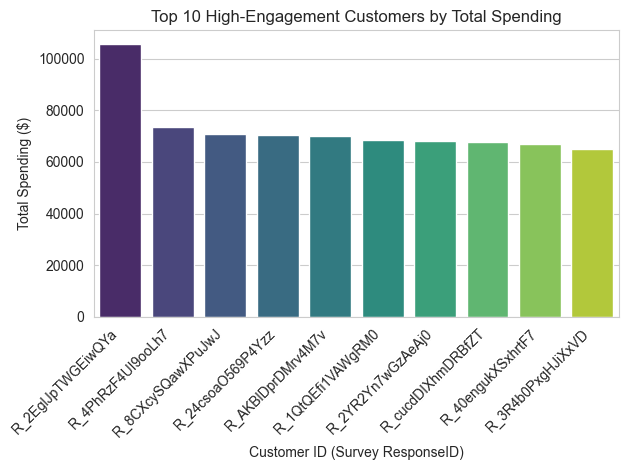

In [75]:
from pyspark.sql.functions import desc

# Top 10 High-Engagement Customers

### Calculating 'Total_Purchase_Value' for each transaction.
df_with_total_value = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
)

### Calculating total spending per customer.
customer_spending = df_with_total_value.groupBy("Survey ResponseID").agg(
    sum("Total_Purchase_Value").alias("Total_Spending")
)

### Identifying the top 10 customers by total spending.
top_10_customers_spark = customer_spending.orderBy(desc("Total_Spending")).limit(10)

# Convert to Pandas for visualisation
top_10_customers_pandas = top_10_customers_spark.toPandas()

# Plot
n_top=10
sns.barplot(
    x='Survey ResponseID',
    y='Total_Spending',
    data=top_10_customers_pandas,
    hue='Survey ResponseID',
    palette='viridis',
    legend=False
)
plt.title(f'Top {n_top} High-Engagement Customers by Total Spending')
plt.xlabel('Customer ID (Survey ResponseID)')
plt.ylabel('Total Spending ($)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 3.10 Seasonal trends in product purchases and their impact on revenues <font color = red>[5 marks]</font> <br>

Investigate the seasonal trends in product purchases and their impact on the overall revenue.

In [77]:
# Seasonal Trends in Product Purchases and Their Impact on Revenue

# from pyspark.sql.functions import col, year, month, sum

# Extract year and month
### Calculating 'Total_Purchase_Value' for each transaction.
df_with_total_value = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
)

### Extracting Year and Month from 'parsed_date' and adding them as new columns.
df_with_date_parts = df_with_total_value.withColumn(
    "purchase_year", year(col("parsed_date"))
).withColumn(
    "purchase_month", month(col("parsed_date"))
)

### Grouping by Year and Month, summing Total Revenue for each month.
seasonal_revenue_spark = df_with_date_parts.groupBy("purchase_year", "purchase_month").agg(
    sum("Total_Purchase_Value").alias("Monthly_Revenue")
).orderBy("purchase_year", "purchase_month")

# Convert to Pandas for visualisation
seasonal_revenue_pandas = seasonal_revenue_spark.toPandas()

### Creating a combined 'Year-Month' string for better plotting labels on the x-axis,
### and adding 'purchase_month' with leading zeros if it's a single digit (e.g., 1 -> 01).
seasonal_revenue_pandas['year_month'] = seasonal_revenue_pandas['purchase_year'].astype(str) + '-' + \
                                       seasonal_revenue_pandas['purchase_month'].astype(str).str.zfill(2)

# Plot
plt.figure(figsize=(16, 7))
sns.lineplot(
    x='year_month',
    y='Monthly_Revenue',
    data=seasonal_revenue_pandas,
    marker='o' 
)
plt.title('Monthly Revenue Trends Over Time')
plt.xlabel('Year-Month')
plt.ylabel('Total Monthly Revenue ($)')
plt.xticks(rotation=90, ha='right') 
plt.grid(True, linestyle='--', alpha=0.6) 
plt.tight_layout() 
plt.show()

### Note:
- The fall at the end of the line plot is due to the insufficiency of data post 2022. This can be checked with the help of the code given below.

In [79]:
# Getting the count of all transactions
total_transactions_count = cleaned_data.count()
print(f"Total number of transactions: {total_transactions_count}")

# Getting the count of transactions in 2022 using the 'parsed_date' column
transactions_2022 = cleaned_data.filter(year(col("parsed_date")) == 2022)
count_2022 = transactions_2022.count()
print(f"Number of transactions in 2022: {count_2022}")

# Getting the count of transactions in 2023 using the 'parsed_date' column
transactions_2023 = cleaned_data.filter(year(col("parsed_date")) == 2023)
count_2023 = transactions_2023.count()
print(f"Number of transactions in 2023: {count_2023}")

# Comparing the counts
percentage_2023 = (count_2023 / count_2022) * 100
print(f"\nTransactions in 2023 account for {percentage_2023:.2f}% of transactions in 2022.")

# Comparing the counts
percentage_2023 = (count_2023 / total_transactions_count) * 100
print(f"Transactions in 2023 account for {percentage_2023:.2f}% of total transactions.")

Total number of transactions: 1631716
Number of transactions in 2022: 404804
Number of transactions in 2023: 36841

Transactions in 2023 account for 9.10% of transactions in 2022.
Transactions in 2023 account for 2.26% of total transactions.


## 3.11 Customer location vs purchasing behavior <font color = red>[5 marks]</font> <br>

Examine the relationship between customer's location and their purchasing behaviors

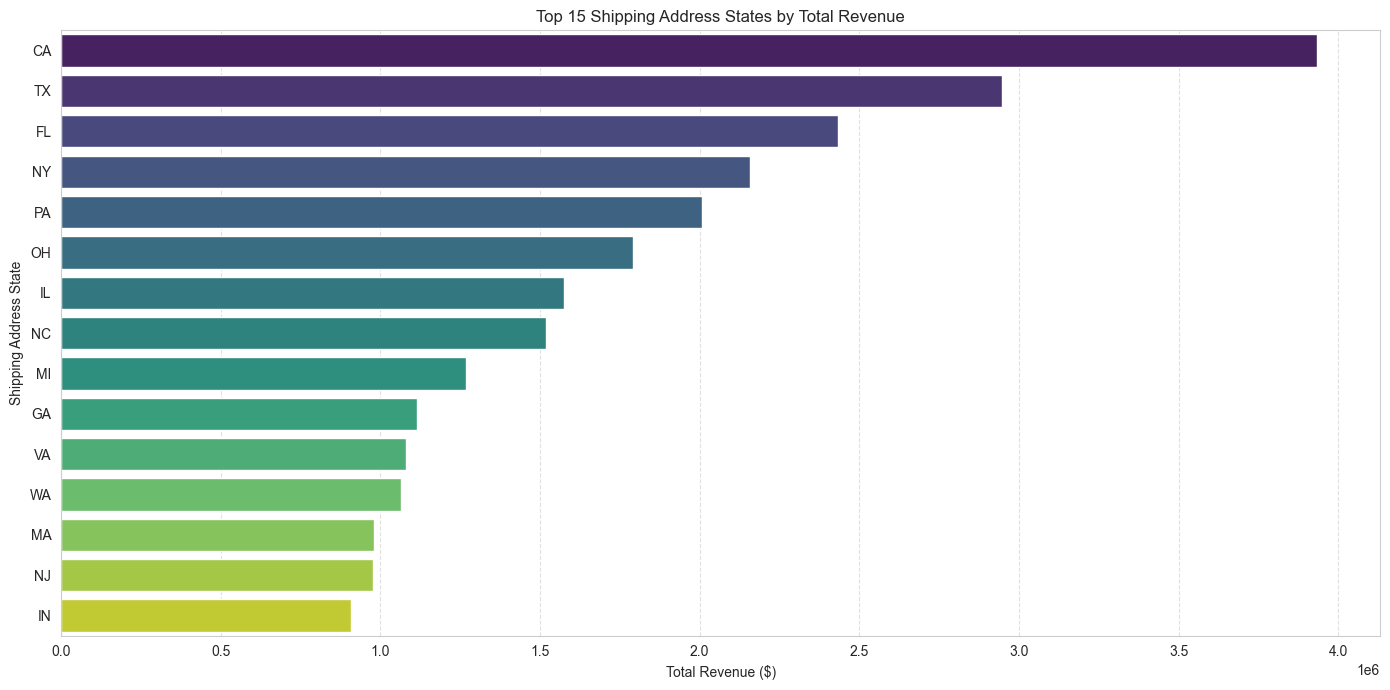

In [81]:
# Relationship Between Customer Location and Purchase Behavior

### Calculating 'Total_Purchase_Value' for each transaction.
df_with_total_value = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
)

# Group purchases by state and total spend
### Grouping purchases by 'Shipping Address State' and aggregating total spend and total number of purchases.
customer_location_analysis_spark = df_with_total_value.groupBy("Shipping Address State").agg(
    sum("Total_Purchase_Value").alias("Total_Revenue_by_State"),
    count(col("Survey ResponseID")).alias("Number_of_Purchases")
).orderBy(col("Total_Revenue_by_State").desc())

# Convert to Pandas for visualisation
customer_location_analysis_pandas = customer_location_analysis_spark.toPandas()

# Plot revenue by state
n_top_states=15
top_n_states=customer_location_analysis_pandas.head(n_top_states)

plt.figure(figsize=(14, 7))
sns.barplot(
    x='Total_Revenue_by_State',
    y='Shipping Address State',
    data=top_n_states,
    palette='viridis',
    hue='Shipping Address State',
    legend=False
)
plt.title(f'Top {n_top_states} Shipping Address States by Total Revenue')
plt.xlabel('Total Revenue ($)')
plt.ylabel('Shipping Address State')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Inference:
- Top 6 states out of these 15 states are: California (CA), Texas (TX), Florida (FL), New York (NY), Pennsylvania (PA) and Ohio (OH).

#4. Customer Segmentation and Insights <font color = red>[45 marks]</font> <br>


## 4.1 Perform RFM Analysis <font color = red>[10 marks]</font> <br>

RFM Analysis is a powerful customer segmentation technique used to evaluate and quantify customer value based on three key dimensions:
- **Recency**,
- **Frequency**,
- **Monetary**.

This method is particularly effective in identifying high-value customers, optimizing marketing strategies, and improving customer retention in the e-commerce industry.


### 1. Recency (R)
Recency measures how recently a customer made a purchase Customers who have purchased more recently are more likely to respond to promotions and offers.
- **Application:** By ranking customers based on the number of days since their last transaction, you can prioritize those who are most engaged.

### 2. Frequency (F)
Frequency counts the number of purchases a customer has made over a given period.
Frequent purchasers tend to be more loyal and are often a source of recurring revenue.
- **Application:** Analyzing purchase frequency helps in identifying consistent buyers and understanding their buying patterns.

### 3. Monetary (M)
Monetary value represents the total amount of money a customer has spent.
Customers who spend more are often more profitable, making them ideal targets for retention and upsell strategies.
- **Application:** By assessing the monetary contribution, you can distinguish between high-value and low-value customers.


### Prepare data for RFM Analysis <font color = red>[2 marks]</font> <br>

### Prepare data for RFM Analysis

In [87]:
from pyspark.sql.functions import datediff, max, count, sum, lit

# Get the latest order date in the dataset
latest_date_spark = cleaned_data.agg(max(col("parsed_date")).alias("LatestDate")).collect()[0]["LatestDate"]
current_snapshot_date = to_date(lit(latest_date_spark))

# Calculate RFM metrics
### Computing 'Recency' as the difference between the latest date and the most recent order date
recency_df = cleaned_data.groupBy("Survey ResponseID").agg(
    max(col("parsed_date")).alias("LastPurchaseDate")
).withColumn(
    "Recency",
    datediff(current_snapshot_date, col("LastPurchaseDate"))
).select("Survey ResponseID", "Recency")

### Computing 'Frequency' as the count of distinct product purchases (ASIN/ISBN)
frequency_df = cleaned_data.groupBy("Survey ResponseID").agg(
    count("*").alias("Frequency")
).select("Survey ResponseID", "Frequency")

### Computing 'Monetary' as the total spending sum for each customer
monetary_df = cleaned_data.withColumn(
    "LineItemTotal",
    col("Price_numeric") * col("Quantity_numeric")
).groupBy("Survey ResponseID").agg(
    sum(col("LineItemTotal")).alias("Monetary")
).select("Survey ResponseID", "Monetary")

### Joining the RFM metrics into a single DataFrame
rfm_df = recency_df.join(frequency_df, on="Survey ResponseID", how="inner") \
                   .join(monetary_df, on="Survey ResponseID", how="inner")

# Filter out customers with no purchases
rfm_df = rfm_df.filter((col("Monetary") > 0) & (col("Frequency") > 0))

# Show RFM data
print("\nRFM Data Sample:")
rfm_df.show(5)

print(f"\nTotal customers for RFM analysis: {rfm_df.count()}")
rfm_df.printSchema()


RFM Data Sample:
+-----------------+-------+---------+--------+
|Survey ResponseID|Recency|Frequency|Monetary|
+-----------------+-------+---------+--------+
|R_10TV1zyi4yCEEkl|    176|     1036|27612.92|
|R_1LBvKYfg8hgoloJ|   1547|        7|  326.78|
|R_3GD1CL4OyjglmbZ|    167|      729|16610.88|
|R_2dyITPHbbfmCXJn|    170|      502|15262.13|
|R_1mxX9jjBSLwxiDU|    196|      242| 2653.55|
+-----------------+-------+---------+--------+
only showing top 5 rows


Total customers for RFM analysis: 4960
root
 |-- Survey ResponseID: string (nullable = true)
 |-- Recency: integer (nullable = true)
 |-- Frequency: long (nullable = false)
 |-- Monetary: decimal(31,2) (nullable = true)



In [88]:
from pyspark.sql.functions import log1p

# Apply log transformation to skewed features
rfm_log_transformed_df = rfm_df.withColumn("Recency_log", log1p(col("Recency"))) \
                               .withColumn("Frequency_log", log1p(col("Frequency"))) \
                               .withColumn("Monetary_log", log1p(col("Monetary")))

# Convert to Pandas DataFrame (for scikit-learn compatibility)
rfm_pandas_df = rfm_log_transformed_df.select(
    "Survey ResponseID", "Recency_log", "Frequency_log", "Monetary_log"
).toPandas()

# Scale features using StandardScaler
from sklearn.preprocessing import StandardScaler

# Defining the features to be scaled
features_to_scale = ['Recency_log', 'Frequency_log', 'Monetary_log']

# Initializing the StandardScaler
scaler = StandardScaler()

### Fitting the scaler to the data and transforming the data
scaled_features_array = scaler.fit_transform(rfm_pandas_df[features_to_scale])

### Converting the scaled array back into a Pandas DataFrame for easier handling
scaled_rfm_df = pd.DataFrame(scaled_features_array, columns=[f"{f}_scaled" for f in features_to_scale])

### Re-attaching the 'Survey ResponseID' to the scaled data,
### this is crucial for linking back to individual customers.
final_rfm_processed_df = pd.concat([rfm_pandas_df['Survey ResponseID'], scaled_rfm_df], axis=1)

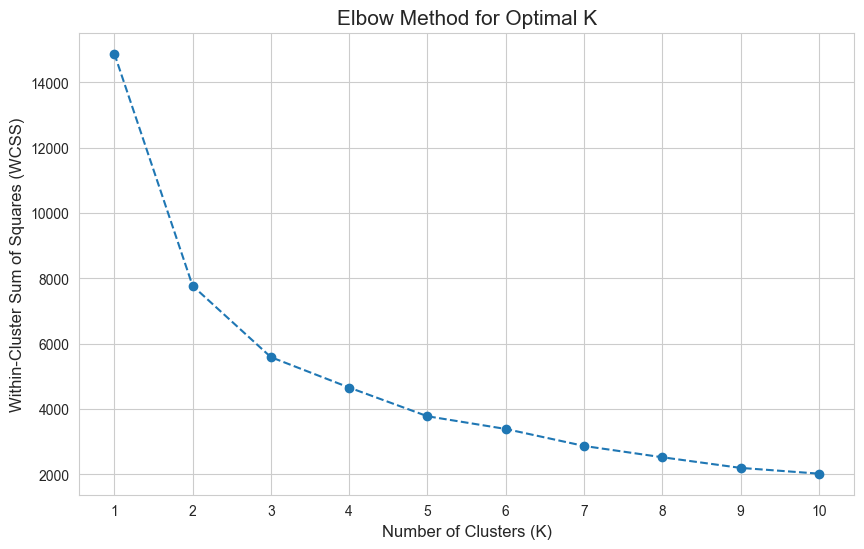

In [89]:
from sklearn.cluster import KMeans

### Defining the features to be used for clustering,
### these are the scaled log-transformed RFM features
X = final_rfm_processed_df[['Recency_log_scaled', 'Frequency_log_scaled', 'Monetary_log_scaled']]

# Calculate the Within-Cluster Sum of Squares (WCSS)
wcss = []
for i in range(1, 11): # Test k from 1 to 10
    kmeans = KMeans(n_clusters=i, random_state=42, n_init='auto')
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve with the number of clusters on the x-axis and WCSS on the y-axis
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K', fontsize=15)
plt.xlabel('Number of Clusters (K)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

### Inference:
- From the above diagram, it can be observed that the decrease in WCSS beyond K=3 is only marginal, therefore it makes sense to take the optimal number of clusters as 3.

In [91]:
### Assigning optimal number of clusters
optimal_k = 3
X = final_rfm_processed_df[['Recency_log_scaled', 'Frequency_log_scaled', 'Monetary_log_scaled']]

# Fit the K-Means model using the optimal number of clusters obtained after understanding the elblow plot
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans_model.fit(X)

# Add the assigned cluster labels to the Pandas DataFrame and convert back to PySpark if needed
final_rfm_processed_df['Cluster'] = kmeans_model.labels_

rfm_clustered_pyspark_df = spark.createDataFrame(final_rfm_processed_df)

In [92]:
# Convert the full RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation
rfm_clustered_pandas_df = rfm_clustered_pyspark_df.toPandas()

# Generate a pairplot to visualise the relationships between the numeric RFM columns
g = sns.pairplot(
    rfm_clustered_pandas_df,
    vars=['Recency_log_scaled', 'Frequency_log_scaled', 'Monetary_log_scaled'],
    hue='Cluster',
    palette='viridis',
    diag_kind='kde',
    plot_kws={'alpha': 0.6, 's': 30}
)
plt.suptitle('Pairplot of RFM Segments (Log-Scaled & Clustered)', y=1.02, fontsize=16)
g._legend.set_bbox_to_anchor((1.05, 0.5))
g._legend.set_title("Cluster")
g._legend.set_frame_on(True)
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

### Characteristics of each clusters:

- Cluster 0 (Purple): "Champions" or "Loyal High-Value Customers"
1. Recency: Low (most negative log-scaled values), meaning they made their last purchase very recently.
2. Frequency: High (less negative log-scaled values), meaning they purchase frequently.
3. Monetary: High (less negative log-scaled values), meaning they spend the most.
4. Description: This is the most valuable segment, characterized by recent, frequent, and high-spending behavior.

- Cluster 1 (Teal): "Churned" or "At-Risk" customers
1. Recency: High (less negative log-scaled values), meaning they made their last purchase a long time ago.
2. Frequency: Low (more negative log-scaled values), meaning they purchase infrequently.
3. Monetary: Low (more negative log-scaled values), meaning they spend very little.
4. Description: This cluster is the least engaged and least valuable segment, having not purchased recently, not purchasing often, and spending very little when they do.

- Cluster 2 (Yellow): "Promising Customers" or "Regular Buyers"
1. Recency: Mid-range to low (more recent purchases than Cluster 1, but perhaps not as recent as Cluster 0).
2. Frequency: Mid-range to high, indicating regular purchases but perhaps not as frequent as Cluster 0.
3. Monetary: Mid-range to high, indicating good spending habits but not as high as Cluster 0.
4. Description: These customers are engaged, recent, and spend a good amount. This segment has high potential to be nurtured into "Champions" (Cluster 0).

### Behavioral Trends Analysis <font color = red>[8 marks]</font> <br>

Perform RFM analysis to study the behavior of customers to tailor marketing strategies

#### Note: The following two codes have been executed in the above codes, executing them again will only be a repetition.

In [96]:
# Import necessary PySpark functions for data processing

# Group the dataset by 'Survey ResponseID' to calculate RFM (Recency, Frequency, Monetary) metrics

# Compute 'Recency' as the difference between the latest date and the most recent order date
# Compute 'Frequency' as the count of distinct product purchases (ASIN/ISBN)
# Compute 'Monetary' as the total spending sum for each customer

# Rename columns if required and normlise the distributions

# Convert the processed RFM dataset back to Pandas for sklearn compatibility for clustering

In [97]:
# Apply K-Means clustering

# Fit the K-Means model and predict cluster labels for each customer

# Add the predicted cluster labels to the Pandas DataFrame

# Convert the Pandas DataFrame back to a PySpark DataFrame

Analyse the Cluster Distribution by Income <font color = red>[2 marks]</font> <br>


In [99]:
#Trend 1: Cluster Distribution by Income

# Import the necessary function for counting records in PySpark
import numpy as np

# Join the RFM dataset with the survey dataset using a common key
rfm_income_df = rfm_clustered_pyspark_df.join(
    merged_data.select("Survey ResponseID", "income_numerical"),
    on="Survey ResponseID",
    how="inner"
)

# Aggregate data to count the number of customers per Cluster-Income group
cluster_income_counts_spark = rfm_income_df.groupBy("Cluster", "income_numerical").agg(
    count(col("Survey ResponseID")).alias("Customer_Count")
).orderBy("Cluster", "income_numerical")

# Convert the aggregated data from PySpark DataFrame to Pandas DataFrame for visualisation
cluster_income_counts_pd = cluster_income_counts_spark.toPandas()

### Applying Log Transformation to Customer_Count
### Adding 1 before taking log to handle cases where count might be 0
cluster_income_counts_pd['Customer_Count_Log10'] = np.log10(cluster_income_counts_pd['Customer_Count'] + 1)


income_labels = {
    0: 'Less than $25K',
    1: '$25K - $49.9K',
    2: '$50K - $74.9K',
    3: '$75K - $99.9K',
    4: '$100K - $149.9K',
    5: '$150K or more'
}
cluster_income_counts_pd['Income_Group'] = cluster_income_counts_pd['income_numerical'].map(income_labels)

### Ensuring the Income_Group categories are ordered correctly for consistent plotting
ordered_income_labels = [
    'Less than $25K',
    '$25K - $49.9K',
    '$50K - $74.9K',
    '$75K - $99.9K',
    '$100K - $149.9K',
    '$150K or more'
]
cluster_income_counts_pd['Income_Group'] = pd.Categorical(
    cluster_income_counts_pd['Income_Group'],
    categories=ordered_income_labels,
    ordered=True
)
cluster_income_counts_pd = cluster_income_counts_pd.sort_values(['Cluster', 'Income_Group'])

# Plot
plt.figure(figsize=(14, 8))
sns.barplot(
    data=cluster_income_counts_pd,
    x='Income_Group',
    y='Customer_Count_Log10',
    hue='Cluster',
    palette='viridis'
)
plt.title('Cluster Distribution by Income Group (Log10 Scale)', fontsize=16)
plt.xlabel('Income Group', fontsize=12)
plt.ylabel('Number of Customers (Log10 Scale)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- Cluster 0 has a significantly higher number of customers in the middle to higher income brackets.
- Cluster 1 has a consistently very low number of customers across all income groups.
- Cluster 2 has a notable presence in the lower to mid-income categories.

Analyse the Average Spending by Cluster <font color = red>[2 marks]</font> <br>


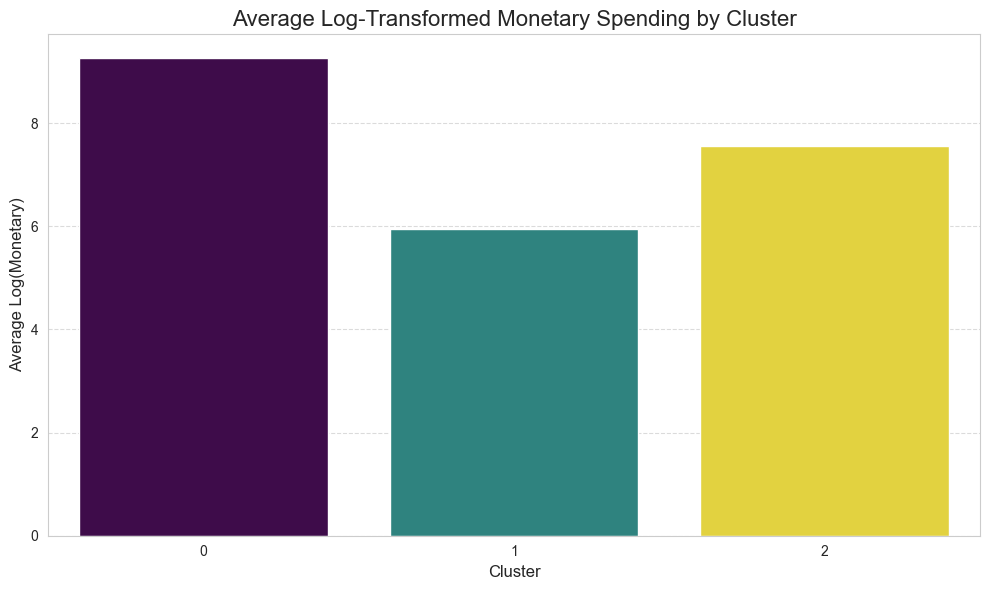

In [102]:
#Trend 2: Average Spending by Cluster

# Import the required function for calculating averages in PySpark
from pyspark.sql.functions import avg

### Joining the clustered DataFrame with the log-transformed RFM DataFrame
rfm_log_with_clusters = rfm_log_transformed_df.join(
    rfm_clustered_pyspark_df.select("Survey ResponseID", "Cluster"),
    on="Survey ResponseID",
    how="inner"
)

# Compute the average values of 'Recency_log', 'Frequency', and 'Monetary_log' for each customer cluster
cluster_avg_log_rfm_spark = rfm_log_with_clusters.groupBy("Cluster").agg(
    avg(col("Recency_log")).alias("Avg_Recency_Log"),
    avg(col("Frequency_log")).alias("Avg_Frequency_Log"),
    avg(col("Monetary_log")).alias("Avg_Monetary_Log")
).orderBy("Cluster")

# Convert the aggregated cluster summary from PySpark DataFrame to Pandas DataFrame for visualisation
cluster_avg_log_rfm_pd = cluster_avg_log_rfm_spark.toPandas()

# Generate a bar plot to visualise the average monetary spending per cluster
plt.figure(figsize=(10, 6))
sns.barplot(
    data=cluster_avg_log_rfm_pd,
    x='Cluster',
    y='Avg_Monetary_Log',
    hue='Cluster',
    palette='viridis',
    legend=False
)
plt.title('Average Log-Transformed Monetary Spending by Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Average Log(Monetary)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- It can inferred from the chart that Cluster 0 are the highest-value customers in terms of spending, Cluster 1 being the lowest, and Cluster 2 lying in between. Marketing efforts can be tailored keeping above attribute in mind.

Analyse the Purchase Frequency vs. Recency <font color = red>[2 marks]</font> <br>


In [105]:
#Trend 3: Purchase Frequency vs. Recency

### Joining the cluster labels back to the original RFM values (rfm_df)
rfm_original_with_clusters = rfm_df.join(
    rfm_clustered_pyspark_df.select("Survey ResponseID", "Cluster"),
    on="Survey ResponseID",
    how="inner"
)

# Convert the RFM dataset from PySpark DataFrame to Pandas DataFrame for visualisation
rfm_plot_pd = rfm_original_with_clusters.select("Recency", "Frequency", "Cluster").toPandas()

# Generate a scatter plot to analyse the relationship between Purchase Frequency and Recency
plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=rfm_plot_pd,
    x='Recency',
    y='Frequency',
    hue='Cluster',
    palette='viridis',
    alpha=0.6,
    s=50
)
plt.title('Purchase Frequency vs. Recency by Customer Cluster', fontsize=16)
plt.xlabel('Recency (Days Since Last Purchase)', fontsize=12)
plt.ylabel('Frequency (Number of Purchases)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

### Inferences:
- Reasons behind high recency of Cluster 1 should be identified and addressed to bring them back into stores, whereas efforts should be put in to increase the engagement of Cluster 2.

Analyse the top categories by clusters <font color = red>[2 marks]</font> <br>


In [108]:
#Trend 4: Top Categories by Cluster

# Import the necessary function to calculate the sum in PySpark
from pyspark.sql.functions import rank
from pyspark.sql.window import Window

# Join the merged dataset with the RFM dataset to associate each customer with their respective cluster
df_transactions_with_total_value = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
).filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

### Joining the transaction data with cluster information
transactions_with_clusters = df_transactions_with_total_value.join(
    rfm_clustered_pyspark_df.select("Survey ResponseID", "Cluster"),
    on="Survey ResponseID",
    how="inner"
)

# Group the filtered data by 'Category' and compute the total spending in each category
cluster_category_spending_spark = transactions_with_clusters.groupBy("Cluster", "Category").agg(
    sum(col("Total_Purchase_Value")).alias("Total_Spending")
)

# Order the categories by total spending in descending order and select the top 5 highest spending categories
window_spec = Window.partitionBy("Cluster").orderBy(col("Total_Spending").desc())
cluster_category_ranking_spark = cluster_category_spending_spark.withColumn(
    "rank",
    rank().over(window_spec)
).filter(col("rank") <= 5)

# Convert the top categories dataset from PySpark DataFrame to Pandas DataFrame for visualisation
top_categories_by_cluster_pd = cluster_category_ranking_spark.toPandas()

# Plot the cluster

### Sorting the DataFrame for consistent plotting order within each facet.
top_categories_by_cluster_pd = top_categories_by_cluster_pd.sort_values(by=['Cluster', 'Total_Spending'], ascending=[True, False])

g = sns.catplot(
    data=top_categories_by_cluster_pd,
    x='Total_Spending',
    y='Category',
    hue='Category',
    col='Cluster',
    kind='bar',
    col_wrap=2,
    height=5, aspect=1.2,
    sharex=False,
    palette='viridis',
    legend=False
)
g.set_axis_labels("Total Spending ($)", "Product Category")
g.set_titles("Cluster {col_name}")
g.fig.suptitle('Top 5 Product Categories by Spending per Cluster', y=1.02, fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Inferences:
- "ABIS_BOOK" consistently appears as top spending category, in all the three clusters. In addition to this, "SHOES" is also having presence in all the three clusters. "NUTRITIONAL_SUPPLEMENT" and "HEADPHONES" are also highly sought after categories.
- Due to the amount of money spent, Cluster 0 seems likely to include bulk buyers, wholesalers, or institutional customers focusing on books and health/wellness products.
- Due to the categories the money is spent on, Cluster 1 seems likely to include tech-savvy individuals and gamers. However, this cluster has much lower total spending across all categories.
- Based on their purchasing habits, Cluster 2 seems to include fitness, wellness and entertainment oriented individuals.

## 4.2 Insights <font color = red>[35 marks]</font> <br>


### 4.2.1 When to schedule effective promotions. <font color = red>[3 marks]</font> <br>

Compare sales across weekdays to schedule effective promotions

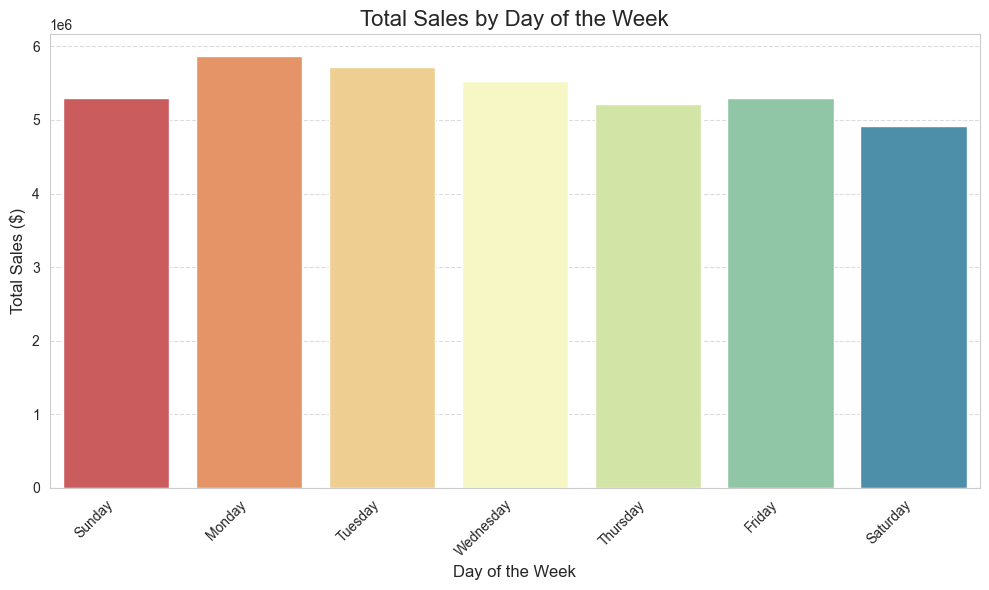

In [112]:
#Compare sales across weekdays to schedule effective promotions

from pyspark.sql.functions import dayofweek

# Extract day of the week (1 = Sunday, 7 = Saturday)
### Calculating the 'Total_Purchase_Value' for each transaction,
### and extracting the day of the week (1=Sunday, 7=Saturday).
df_sales_by_day = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
).filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
).withColumn(
    "DayOfWeek",
    dayofweek(col("parsed_date"))
)

# Group by weekday and sum total sales
### Aggregating the total sales for each day of the week.
daily_sales_spark = df_sales_by_day.groupBy("DayOfWeek").agg(
    sum(col("Total_Purchase_Value")).alias("Total_Sales")
).orderBy("DayOfWeek")

# Convert to Pandas for visualisation
daily_sales_pd = daily_sales_spark.toPandas()

### Mapping the numeric DayOfWeek values to actual weekday names
weekday_mapping = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}
daily_sales_pd['Day_Name'] = daily_sales_pd['DayOfWeek'].map(weekday_mapping)

### Ensuring the 'Day_Name' column is a categorical type with the correct order for plotting
ordered_days = [
    'Sunday', 'Monday', 'Tuesday', 'Wednesday',
    'Thursday', 'Friday', 'Saturday'
]
daily_sales_pd['Day_Name'] = pd.Categorical(
    daily_sales_pd['Day_Name'],
    categories=ordered_days,
    ordered=True
)

### Sorting the DataFrame by the ordered categorical 'Day_Name'
daily_sales_pd = daily_sales_pd.sort_values('Day_Name')

# Plot sales by weekday
plt.figure(figsize=(10, 6))
sns.barplot(
    data=daily_sales_pd,
    x='Day_Name',
    y='Total_Sales',
    hue='Day_Name',
    palette='Spectral',
    legend=False
)
plt.title('Total Sales by Day of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- Modest incentives such as discounts, deals (like buy three, get one free), etc., should be provided on Thursdays and Fridays, whereas high incentives should be provided on weekends to increase the sales.

### 4.2.2 Top-selling Products <font color = red>[2 marks]</font> <br>

Identify top-selling products by considering revenue and engagement metrics

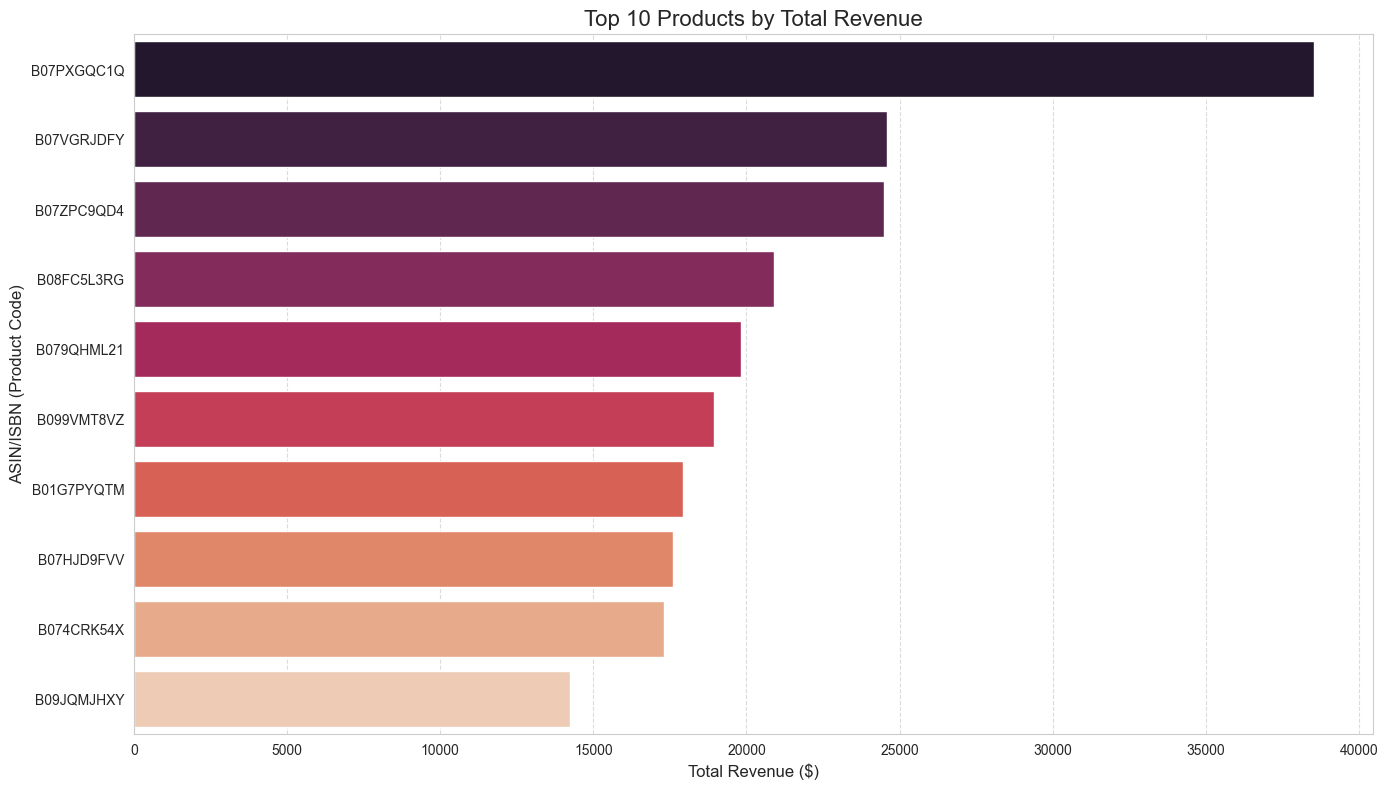

In [115]:
#Identify top-selling products using revenue and engagement metrics

### Calculating 'Total_Purchase_Value' for each transaction line item,
### and filtering for values greater than 0 to ensure valid purchases contribute to revenue.
df_products_with_revenue = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
).filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

# Group by product and sum revenue
product_revenue_spark = df_products_with_revenue.groupBy("ASIN/ISBN (Product Code)").agg(
    sum(col("Total_Purchase_Value")).alias("TotalRevenue")
)

# Get top 10 products by revenue
top_10_products_spark = product_revenue_spark.orderBy(
    col("TotalRevenue").desc()
).limit(10)

# Convert to Pandas for visualisation
top_10_products_pd = top_10_products_spark.toPandas()

# Plot top products by revenue
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_10_products_pd,
    x='TotalRevenue',
    y='ASIN/ISBN (Product Code)',
    hue='ASIN/ISBN (Product Code)',
    palette='rocket',
    legend=False
)
plt.title('Top 10 Products by Total Revenue', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('ASIN/ISBN (Product Code)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- These are top 10 products by total revenue. It can be observed that best selling product is far ahead than other nine products in the list. Modest incentives could be provided with other nine product to increase their sales and increase the overall revenue.

### 4.2.3 State-wise revenue Distribution <font color = red>[5 marks]</font> <br>

Assess state-wise revenue to focus on high-growth areas

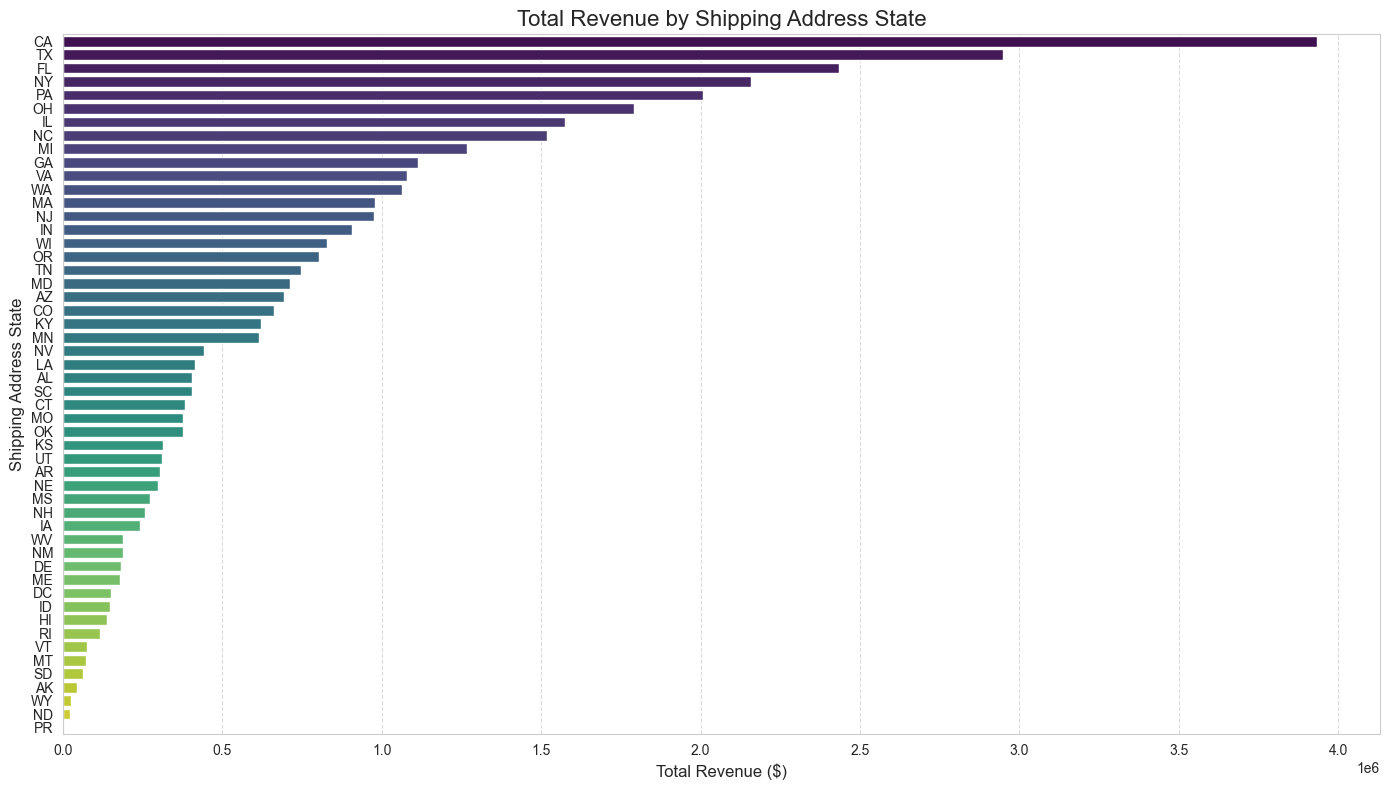

In [118]:
#Assess state-wise revenue to focus on high-growth areas

# Group by state and sum revenue

### Calculating the 'Total_Purchase_Value' for each transaction line item,
### and filtering for values greater than 0 to ensure valid purchases contribute to revenue.
df_state_revenue = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
).filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

### Grouping the filtered data by 'Shipping Address State' and summing their total purchase values
### to get the total revenue generated by each distinct state.
state_revenue_spark = df_state_revenue.groupBy("Shipping Address State").agg(
    sum(col("Total_Purchase_Value")).alias("TotalRevenue")
)

### Ordering the states by 'TotalRevenue' in descending order to easily identify high-revenue areas.
state_revenue_spark = state_revenue_spark.orderBy(
    col("TotalRevenue").desc()
)

# Convert to Pandas for visualisation
state_revenue_pd = state_revenue_spark.toPandas()

# Plot revenue by state
plt.figure(figsize=(14, 8))
sns.barplot(
    data=state_revenue_pd,
    x='TotalRevenue',
    y='Shipping Address State',
    hue='Shipping Address State',
    palette='viridis',
    legend=False
)
plt.title('Total Revenue by Shipping Address State', fontsize=16)
plt.xlabel('Total Revenue ($)', fontsize=12)
plt.ylabel('Shipping Address State', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- High incentives should be provided in bottom 25 states, since these have the highest scope for growth, which will also help to reap the benefits of economies of scale (like higher revenue/logistics costs ratio) for the business.

### 4.2.4 Repeat Purchase Behavior <font color = red>[5 marks]</font> <br>

Examine repeat purchase behavior to enhance retention initiatives.

In [121]:
#Examine repeat purchase behavior to enhance retention initiatives

# from pyspark.sql.functions import count, col

# Count total purchases per customer
### Grouping the cleaned_data by 'Survey ResponseID' and counting the total number of transactions
customer_purchase_counts = cleaned_data.groupBy("Survey ResponseID").agg(
    count("*").alias("total_purchases")
)

# Filter for repeat customers (those with more than one purchase)
repeat_customers_df = customer_purchase_counts.filter(col("total_purchases") > 1)

### Calculating percentage of repeat customers
total_unique_customers = customer_purchase_counts.count()
num_repeat_customers = repeat_customers_df.count()

percentage_repeat_customers = (num_repeat_customers / total_unique_customers) * 100 if total_unique_customers > 0 else 0

### Calculating average number of purchases for repeat customers
avg_purchases_repeat_customers = repeat_customers_df.agg(avg(col("total_purchases"))).collect()[0][0]

print(f"Total Unique Customers: {total_unique_customers}")
print(f"Number of Repeat Customers: {num_repeat_customers}")
print(f"Percentage of Repeat Customers: {percentage_repeat_customers:.2f}%")
print(f"Average Purchases by Repeat Customers: {avg_purchases_repeat_customers:.2f}")

# Show sample data
print("Sample of Repeat Customers Data (Ordered by total_purchases descending)")
repeat_customers_df.orderBy(col("total_purchases").desc()).show(5)

Total Unique Customers: 4960
Number of Repeat Customers: 4955
Percentage of Repeat Customers: 99.90%
Average Purchases by Repeat Customers: 329.31
Sample of Repeat Customers Data (Ordered by total_purchases descending)
+-----------------+---------------+
|Survey ResponseID|total_purchases|
+-----------------+---------------+
|R_8CXcySQawXPuJwJ|           4898|
|R_24csoaO569P4Yzz|           4492|
|R_2EglJpTWGEiwQYa|           3950|
|R_3e5g4lvddcnjkoZ|           3648|
|R_1QtQEfi1VAWgRM0|           3596|
+-----------------+---------------+
only showing top 5 rows



### Inferences:
- Common attributes of bottom 25 percentile customers should be identified and addressed, to drive up the sales.

### 4.2.5 Flagging Potential Fraud <font color = red>[5 marks]</font> <br>

Identify irregular transaction patterns to flag potential fraud.

In [124]:
#Identify irregular transaction patterns to flag potential fraud

from pyspark.sql.functions import stddev #, col, avg,

### Calculating Total Purchase Value for each transaction,
### and filtering for valid purchases where both price and quantity are greater than 0.
df_transactions_with_value = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
).filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

### Calculating the mean and standard deviation of 'Total_Purchase_Value',
### and collecting the aggregate statistics from the Spark DataFrame
spending_stats = df_transactions_with_value.agg(
    avg(col("Total_Purchase_Value")).alias("mean_total_spending"),
    stddev(col("Total_Purchase_Value")).alias("stddev_total_spending")
).collect()[0]

mean_total_spending = float(spending_stats["mean_total_spending"])
stddev_total_spending = float(spending_stats["stddev_total_spending"])

# Calculate the threshold for unusually high spending
# Consider spending to be unusually high if the total spent is greater than the mean + 3 * std dev
fraud_threshold = mean_total_spending + (3 * stddev_total_spending)

# Filter transactions that exceed the threshold
suspicious_transactions_df = df_transactions_with_value.filter(
    col("Total_Purchase_Value") > fraud_threshold
)

# Show suspicious transactions
print("Suspicious Transactions (exceeding Mean + 3*StdDev)")
if suspicious_transactions_df.count() > 0:
    suspicious_transactions_df.show(truncate = False, vertical = True)
    print(f"Total number of suspicious transactions: {suspicious_transactions_df.count()}")
else:
    print("No transactions found that exceed the fraud threshold.")

Suspicious Transactions (exceeding Mean + 3*StdDev)
-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 Survey ResponseID          | R_12sOXAypdX0UEMp                                                                                                                                                                                       
 Order Date                 | 2021-06-21                                                                                                                                                                                              
 Purchase Price Per Unit    | 179.99                                                                                                                                                                                                  
 Quantity               

### Inferences:
- Purchase pattern of these customers should be understood in depth by a panel of experts/senior officials, to identify and address malpractices.

### 4.2.6 Demand Variations across product categories <font color = red>[5 marks]</font> <br>

Perform inventory management by monitoring demand variations across product categories.

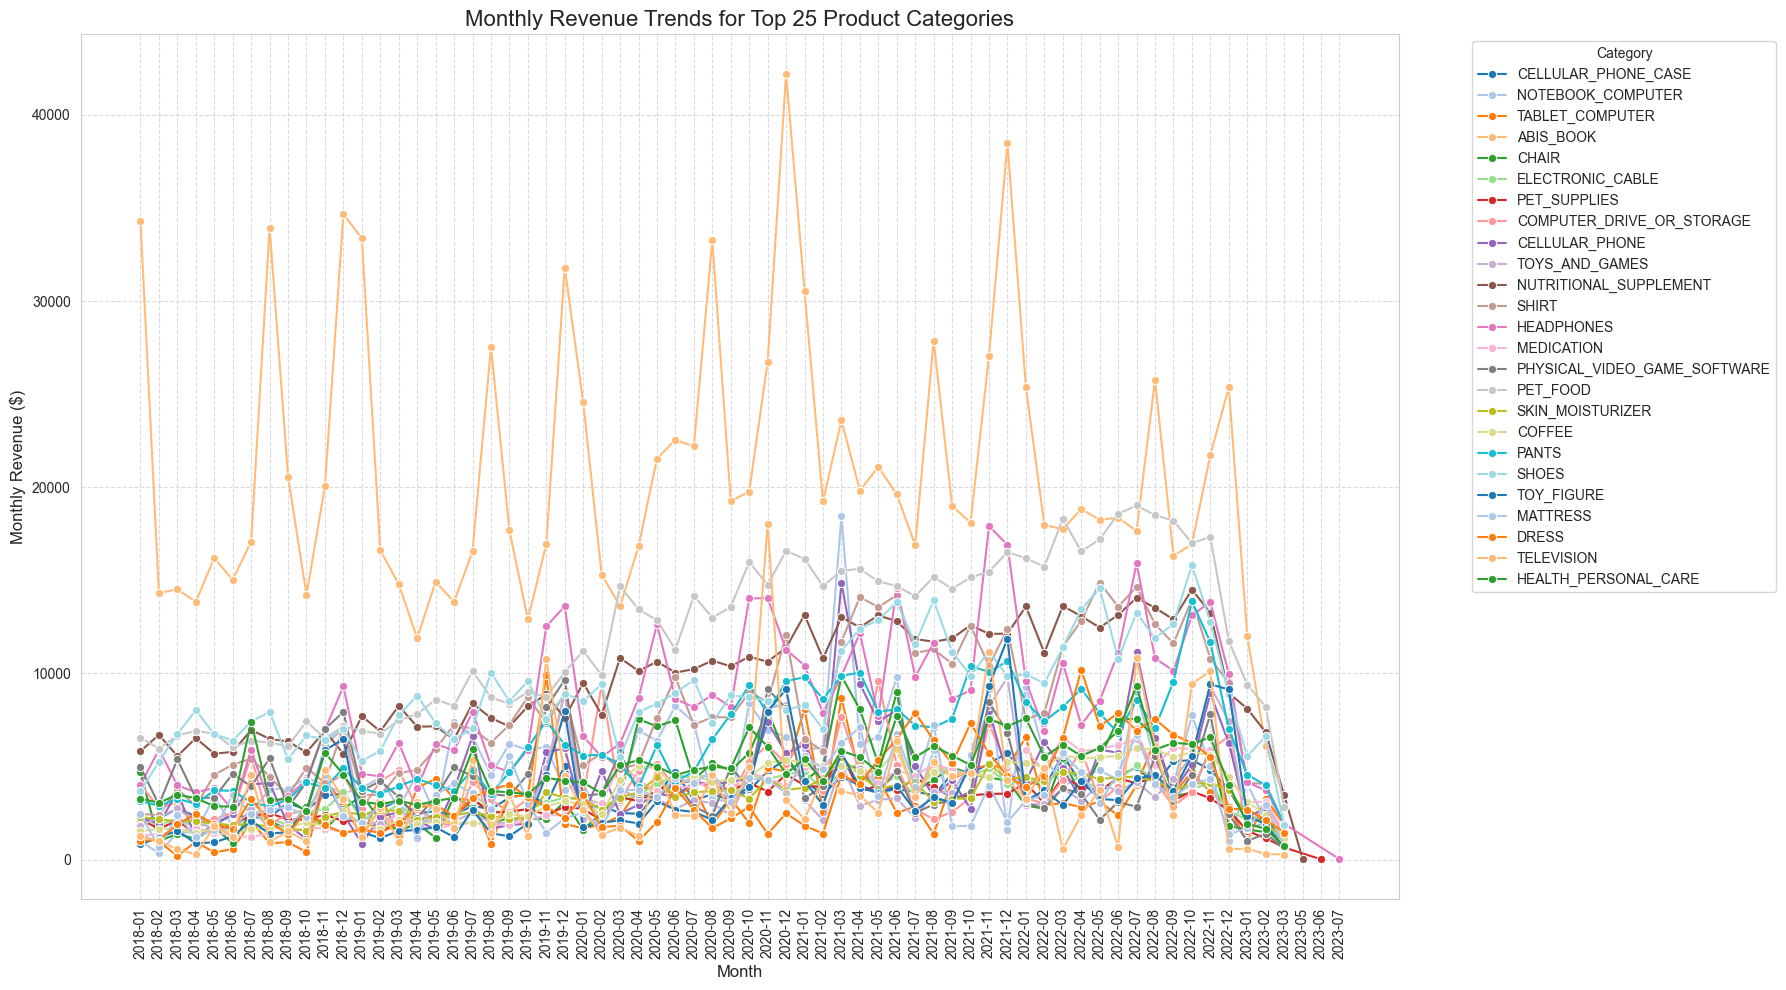

In [127]:
# Monitor demand variations across product categories (Top 25) for inventory management

# from pyspark.sql.functions import col, sum
# import matplotlib.pyplot as plt
# import seaborn as sns

### Calculating total purchase value, extracting the year and month,
### and filtering for valid purchases (price and quantity > 0).
df_with_date_and_value = cleaned_data.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
).withColumn(
    "purchase_year",
    year(col("parsed_date"))
).withColumn(
    "purchase_month",
    month(col("parsed_date"))
).filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

# Group by category and month, summing total revenue
category_monthly_revenue_spark = df_with_date_and_value.groupBy(
    "Category", "purchase_year", "purchase_month"
).agg(
    sum(col("Total_Purchase_Value")).alias("MonthlyRevenue")
).orderBy(
    "purchase_year", "purchase_month"
)

# Compute total revenue per category
category_total_revenue_spark = df_with_date_and_value.groupBy("Category").agg(
    sum(col("Total_Purchase_Value")).alias("TotalCategoryRevenue")
).orderBy(
    col("TotalCategoryRevenue").desc()
)

# Get the top 25 categories by total revenue
top_25_categories_list = [row.Category for row in category_total_revenue_spark.limit(25).collect()]

# Filter category_trends to include only top 25 categories
top_category_trends_spark = category_monthly_revenue_spark.filter(
    col("Category").isin(top_25_categories_list)
)

# Convert to Pandas for visualisation
top_category_trends_pd = top_category_trends_spark.toPandas()

### Creating a combined 'Year-Month' string for the x-axis for better readability on the plot.
top_category_trends_pd['Year-Month'] = top_category_trends_pd['purchase_year'].astype(str) + '-' + \
                                      top_category_trends_pd['purchase_month'].astype(str).str.zfill(2)

### Sorting by 'Year-Month' to ensure the trend lines are continuous and correctly ordered.
top_category_trends_pd = top_category_trends_pd.sort_values(by='Year-Month')

# Plot revenue trends for top 25 categories
plt.figure(figsize=(18, 10))
sns.lineplot(
    data=top_category_trends_pd,
    x='Year-Month',
    y='MonthlyRevenue',
    hue='Category',
    marker='o',
    palette='tab20'
)
plt.title('Monthly Revenue Trends for Top 25 Product Categories', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Monthly Revenue ($)', fontsize=12)
plt.xticks(rotation=90, ha='center', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Category', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Inferences:
- ABIS_BOOK dominates the revenue generation, it consistently outperforms all other categories, often crossing the $30,000/month mark.
- PET_FOOD is also a strong revenue driver, with multiple peaks near 20,000/month, suggesting steady demand, possibly driven by recurring purchases.
- Categories like TELEVISION, NOTEBOOK_COMPUTER, and CELLULAR_PHONE show moderate but volatile revenue, likely reflecting seasonality in demand (like holidays).

### 4.2.7 Assess how bulk purchases affect revenue and supply chain operations <font color = red>[5 marks]</font> <br>

Analyse the impact of how bulk purchasing behavior affects revenue and the overall supply chain operations.

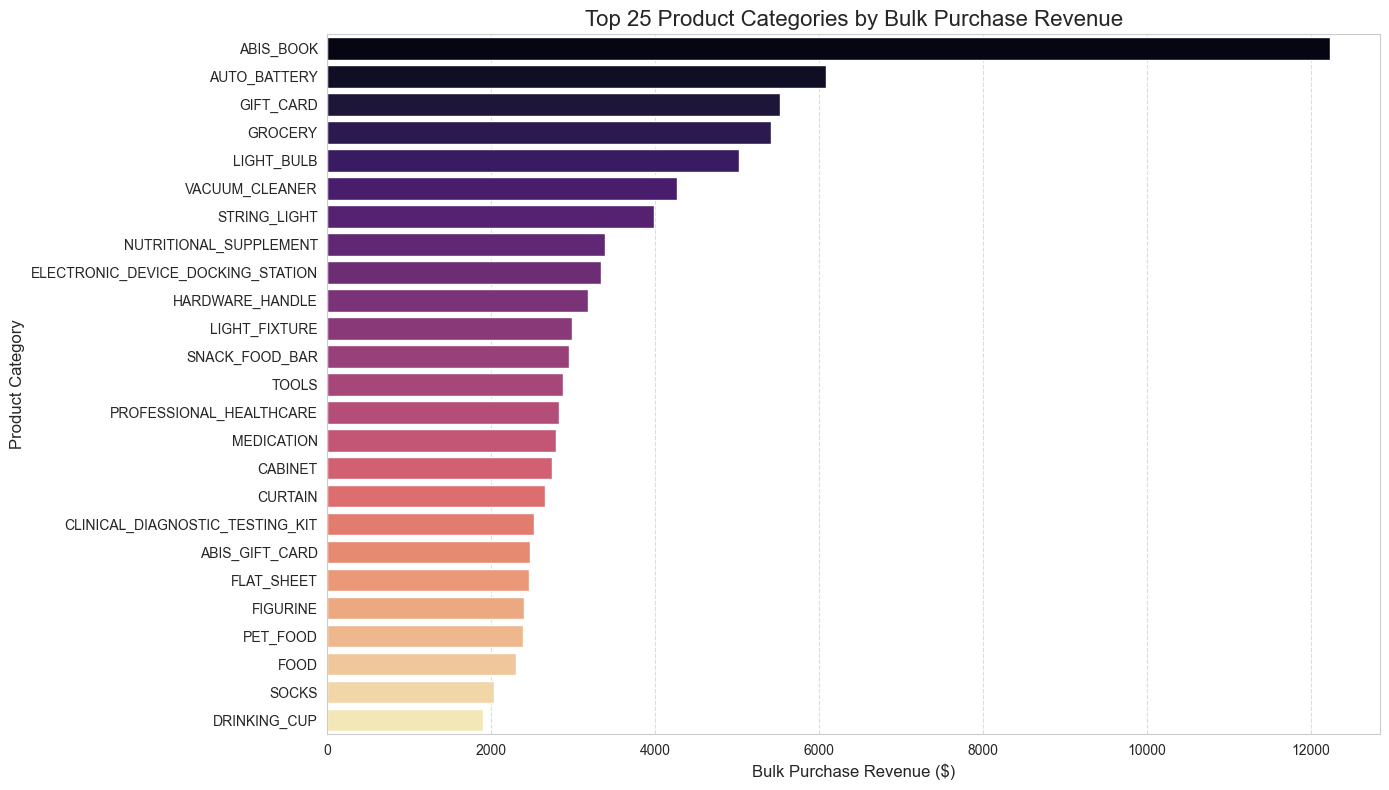

In [130]:
# Assess how bulk purchases affect revenue and supply chain operations

# Filter bulk purchases (Quantity > 5) and compute total revenue per category
bulk_purchases_df = cleaned_data.filter(
    (col("Quantity_numeric") > 5) &
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
).withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
)

### Grouping by 'Category' and summing the 'Total_Purchase_Value' to get total bulk revenue per category.
bulk_revenue_per_category_spark = bulk_purchases_df.groupBy("Category").agg(
    sum(col("Total_Purchase_Value")).alias("BulkRevenue")
)

# Select the top 25 categories by total revenue
top_n_bulk_categories = 25
top_bulk_categories_spark = bulk_revenue_per_category_spark.orderBy(
    col("BulkRevenue").desc()
).limit(top_n_bulk_categories)

# Convert to Pandas for visualisation
top_bulk_categories_pd = top_bulk_categories_spark.toPandas()

# Plot revenue from bulk purchases (Top 25 categories)
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_bulk_categories_pd,
    x='BulkRevenue',
    y='Category',
    hue='Category',
    palette='magma',
    legend=False
)
plt.title(f'Top {top_n_bulk_categories} Product Categories by Bulk Purchase Revenue', fontsize=16)
plt.xlabel('Bulk Purchase Revenue ($)', fontsize=12)
plt.ylabel('Product Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- Adequate inventories of the top 7 categories should be maintained, since the revenue generated by them is considerably higher than the categories below them.
- Marketing efforts for bulk purchases of bottom 10 categories should be enhanced, perhaps with specific B2B pricing or tiered discounts for larger quantities.

### 4.2.8 Compare lifecycle strategies <font color = red>[5 marks]</font> <br>

Compare new and established products to inform and compare lifecycle strategies to make informed decisions.

In [133]:
# Compare new and established products to inform lifecycle strategies

from pyspark.sql.functions import min #, sum

# Compute "Launch Year" as the first recorded sale year for each product
### Extracting the year from the 'parsed_date' column for each transaction
df_with_purchase_year = cleaned_data.withColumn("purchase_year", year(col("parsed_date")))

### Grouping the DataFrame by 'Product' and finding the earliest 'purchase_year' for each product.
product_launch_years_spark = df_with_purchase_year.groupBy("ASIN/ISBN (Product Code)").agg(
    min(col("purchase_year")).alias("LaunchYear")
)

# Join this back to the main dataset
df_with_launch_year = df_with_purchase_year.join(
    product_launch_years_spark,
    on="ASIN/ISBN (Product Code)",
    how="inner"
)

### Filtering for valid purchases where both price and quantity are positive.
df_with_launch_year = df_with_launch_year.filter(
    (col("Price_numeric") > 0) &
    (col("Quantity_numeric") > 0)
)

# Now, we can compute revenue by launch year
df_with_launch_year = df_with_launch_year.withColumn(
    "Total_Purchase_Value",
    col("Price_numeric") * col("Quantity_numeric")
)

### Grouping the DataFrame by 'LaunchYear' and summing the 'Total_Purchase_Value' to find
### the total revenue generated by products launched in that specific year.
revenue_by_launch_year_spark = df_with_launch_year.groupBy("LaunchYear").agg(
    sum(col("Total_Purchase_Value")).alias("TotalRevenue")
)

### Ordering the results by 'LaunchYear' to ensure chronological display in the plot.
revenue_by_launch_year_spark = revenue_by_launch_year_spark.orderBy("LaunchYear")

# Convert to Pandas
revenue_by_launch_year_pd = revenue_by_launch_year_spark.toPandas()

# Plot revenue vs. launch year
plt.figure(figsize=(12, 7))
sns.barplot(
    data=revenue_by_launch_year_pd,
    x='LaunchYear',
    y='TotalRevenue',
    hue='LaunchYear',
    palette='viridis',
    legend=False
)
plt.title('Total Revenue by Product Launch Year', fontsize=16)
plt.xlabel('Product Launch Year', fontsize=12)
plt.ylabel('Total Revenue ($)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Inferences:
- Products launched in Year 2018 has contributed extensively in total revenue, with Year 2020 and 2021 contributing modestly, Year 2019 and 2020 contributing the least. Total revenue of Year 2023 can't be judged due to data insufficiency for that year.

#5 Conclusion <font color = red>[10 marks]</font> <br>

Write your conclusion.

## Proposed marketing strategies based on the characteristics of the clusters are as follows: 

### Cluster 0 (Purple): "Champions" or "Loyal High-Value Customers"
Although numerically the smallest of customer clusters across all income groups, this cluster represents the most valuable customers. These customers demonstrate the highest average monetary spending among all clusters. This segment consists of highly engaged, loyal, and profitable customers who are crucial for business's sustained revenue.

#### Proposed marketing strategy for this cluster:
- Implementing exclusive loyalty and VIP programs offering early access to new products, special sales, tiered rewards, or dedicated customer support.
- Leveraging their purchase history, particularly for dominant categories, to provide personalized recommendations for premium upgrades or complementary high-value products.
- Encouraging them to refer new customers through generous referral programs.
- Ensuring exceptional customer service, and considering launching exclusive offers or new high-value products to this group on highest sales days (Monday, Tuesday, Wednesday) to capitalize on peak engagement.

### Cluster 1 (Teal): "Churned" or "At-Risk" Customers
This is the largest customer segment by count, encompassing a broad range of income groups, particularly strong in the mid-income brackets. However, these customers exhibit low engagement. This cluster also shows the lowest average monetary spending among all clusters. Essentially, this cluster represents customers who are inactive, likely churned, or at a high risk of churning, making them the least valuable segment in terms of current contribution.

#### Proposed marketing strategy for this cluster:
- Enticing them back with compelling win-back campaigns, offering significant discounts, exclusive bundles, or free shipping on their next purchase.
- Undertaking personalized outreach programs, such as "We Miss You" messages that acknowledge their inactivity and remind them of past interactions.
- Showcasing new or popular products to pique their interest by utilizing cost-effective channels like email marketing or retargeting ads.

### Cluster 2 (Yellow): "Potentials" or "Regular Buyers"
This cluster holds the position of the second-highest value segment in terms of average monetary spending. Customers in this cluster show a good level of engagement.  Demographically, this cluster is more prominent within the lower to mid-income groups. This cluster represents engaged and consistent customers who are strong candidates for further nurturing and development into your top-tier "Champions".

#### Proposed marketing strategy for this cluster:
- Nurturing them and encouraging increased frequency and monetary value, moving them towards "Champion" status.
- Implementing incentives such as threshold-based offers ("Spend $X more for Y% off") or product bundling.
- Educating them on product value and benefits, and introducing mid-tier loyalty rewards that motivate them to reach higher spending milestones.
- Providing personalized product recommendations, keeping their income demographics in mind by emphasizing value for money.
- Strategically timing promotions on mid-week days or even Thursday/Friday to reinforce their purchasing habits and boost pre-weekend engagement.